# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, './scripts')
sys.path.insert(1, './FastBDT_git/FastBDT')
import plot_tools
from PyFastBDT import FastBDT
import tools
import os

In [3]:
# Importing reweighting libraries

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import ks_test
import plot_tools
from ks_test import ks_2samp_weighted 

import seaborn as sns # for correlation heatmap

# For hyperparameter optimization
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

from sklearn.metrics import accuracy_score

from customStats import chi2_histogram

In [4]:
data_path = '/home/carlos/projects/Ayudantia/projects/fastbdt/data'
#data_path = tools.analysis_path(data_path)

# Functions

In [5]:
def print_weighted_hist_comparison(MC, RD, cols, weights, title="Hist comparison", 
                                   show_mc=True, num_bins=20, default_MC_w = 1, 
                                   mc_weight_col=None, range=None):
  """Plots histogram of initial MC data against RD, and reweighted MC data. 
  Multiple weights lists can be given to compare many re-weightings of MC data.
  RD and MC are expected to have a "W" weights column, if not found, assigns a default weights of 1 to a created column with this name.

  Parameters:
  MC (pandas.core.frame.DataFrame): Monte Carlo or simulated data
  RD (pandas.core.frame.DataFrame): Real data
  cols (list): Names of the columns to be used
  weights(list): Weights for MC data, can be an array of multiple weights lists with MC length
  title (string): Name template of histograms, prefix for all plots per variable
  show_mc (bool): Show MC histogram
  num_bins (int): Number of bins to display for plots
  default_MC_W = weights of the initial MC data.

  Returns:
  None
  """

  # MC = np.array(MC, dtype=float)
  # MC = MC[np.isfinite(MC)]
  # RD = RD[np.isfinite(RD)]
  COMP = MC.append(RD)
  # Create weights column if not found any
  if 'W' not in RD.columns:
      RD['W'] = 1
  if mc_weight_col:
    if mc_weight_col not in MC.columns:
      MC['W'] = 1
  # Plot per variable in columns
  i = 0
  print(range)
  if range == None:
    range = [None] * len(cols)
  for var in cols:
    # Creating the bins
    if range[i] == None:
      a = min(COMP[var])
      b = max(COMP[var])
    else:
      if range[i][0] == None: a = min(COMP[var])
      else: a = range[i][0]
      if range[i][1] == None: b = max(COMP[var])
      else: b = range[i][1]
    bins = np.histogram(np.hstack((a,b)), bins=num_bins)[1] #get the bin edges
    # Plotting the weighted RD data
    plt.hist(RD[var], bins=bins, alpha=0.5, label="Weighted RD", weights=RD.W, 
             density=True, color="gray", range=range[i])
    # Plotting weighted MC data
    if show_mc:
      plt.hist(MC[var], bins=bins, alpha=0.5, label="Weighted MC", histtype="step", 
               weights=MC[mc_weight_col], linewidth=2.5, density=True, range=range[i])
    # In case weights is a list of multiple MC weights, we plot for each weights list
    if isinstance(weights, list):
      for w in weights:
        #complete_weight = np.multiply(MC["W"], w["weight"])
        complete_weight = w["weight"]
        plt.hist(MC[var], bins=bins, alpha=0.75, label=w["title"], 
                 histtype="step", linewidth=2.5, weights=complete_weight, 
                 density=True, range = range[i])
    else:
      #complete_weight = np.multiply(MC["W"], weights)
      complete_weight = weights
      plt.hist(MC[var], bins=bins, alpha=0.9, label="MC xgb-reweighted", 
               histtype="step", linewidth=2.5, weights=complete_weight, 
               density=True, range = range[i])
    print(range[i])
    plt.legend()
    plt.title(title + " for var " + var)
    plt.show()
    i+=1

In [6]:
def hist_with_pulls(MC, RD, cols, weights=None, title="MC vs RD"):
  """Plots histogram of a weighted MC data against weighted RD including pulls. 
  This function uses plot_tools.compare_plot

  Parameters:
  MC (pandas.core.frame.DataFrame): Monte Carlo or simulated data
  RD (pandas.core.frame.DataFrame): Real data
  weights(list): MC data weights
  cols (list): Names of the columns to be used
  title (string): Name template of histograms, prefix for all plots per variable

  Returns:
  None
  """

  # If no "W" column is found, we assign weight=1 by default
  if 'W' not in RD.columns:
    RD['W'] = 1
  if 'W' not in MC.columns:
    MC['W'] = 1
  for var in cols:
    plot_tools.compare_plot(Data_Num = RD[var], 
                            Data_Den = MC[var], 
                            weights_Num=RD['W'], 
                            weights_Den=weights, 
                            label_Num = '1', 
                            label_Den = '0', 
                            title=title + " for " + var,
                            ks_t = True)

In [7]:
def ks_2samp_per_var(data, weights, cols):
  """Calculates the p-values for two weighted samples of data, separating label 1 from label 0.
  Uses the ks_2samp_weighted to calculate the values

  Parameters:
  data (Any): Merged MC and RD data with 'label' column
  weights (list): Weights for MC to be used in the p-value calculation
  cols (list): Names of the columns of which the p-value is to be known

  Returns:
  results (dict): Dictionary with the name of the columns as keys and the p-values as values
  """
  # MC = np.array(MC, dtype=float)
  # MC = MC[np.isfinite(MC)]
  # RD = RD[np.isfinite(RD)]

  results = {}
  print("ks_2samp_per_var data shape: ", data.query('label==0').shape)
  for var in cols:
    distance = ks_2samp_weighted(data.query('label==1')[var],
                            data.query('label==0')[var],
                            data.query('label==1')['W'],
                            weights)
    print(distance)
    results[var] = distance[1]
  return results

In [8]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, cbar_kws={"shrink": .70}, annot=True, annot_kws={"size": 35 / np.sqrt(len(correlations))}
                )
    plt.show();

## Iterative reweighting functions

In [9]:
def create_training_data(MC, RD, cols):
  """Creates the Training Data by merging the RD and MC data, using the given columns

  Parameters:
  MC (dataframe): MC data with weights "W" column and "label" column
  RD (dataframe): RD data with weights "W" column and "label" column
  cols (list): Names of the columns of which the p-value is to be known

  Returns:
  TRAIN_DATAmask (dataframe):  
  """
  RD_ = RD[cols+['label','W']]
  MC_ = MC[cols+['label','W']]

  print("MC_ lenght loc label=0", MC_.loc[MC_.label == 0].shape)

  TRAIN_DATA = MC_.append(RD_)
  #TRAIN_DATA=TRAIN_DATA[np.isfinite(TRAIN_DATA)]
  
  #TRAIN_DATAmask =TRAIN_DATA[ TRAIN_DATA.W>0]

  return TRAIN_DATA

In [10]:
def apply_weights(RD, MC, RD_w, MC_w=1):
  """Sets 'label' and 'W' columns for RD and MC data, given the weights for RD and MC data respectively

  Parameters:
  RD (dataframe): RD data
  MC (dataframe): MC data
  RD_w (list): RD weights to be applied, they should have the same lenght as the RD data
  MC_w (list): MC weights to be applied, they should have the same lenght as the MC data

  Returns:
  RD, MC: tuple of the new RD and MC dataframes with 'W' and 'label' columns
  """

  # Monte Carlo Data = Background
  # Weights of all events are set to 1
  MC['W'] = MC_w 
  MC['label'] = 0

  # Real Data = Signal
  # This data is the one wants to fit to the MC data
  RD['W'] = RD_w #RD.sW_sum
  RD['label'] = 1
  return RD, MC

In [11]:
# Function to generate the new weights

def xgb_weights(RD, MC, cols, train_data, optimize=True):

  """Creates a model with the given data and does hyperparameter optimization. 
  RD and MC data is required for the Bayesian optimization of hyperparameters.

  Parameters:
  RD (dataframe): RD data
  MC (dataframe): MC data
  cols (list): Names of the columns to be used
  train_data (dataframe): Merged RD and MC data used for training of the model
  optimize (bool): Indicates if hyperoptimization is to be used in the xgboost model

  Returns:
  weigths, model: Tuple of new weights for MC with lenght of the MC data and the trained xgboost model
  """
  model = xgb.XGBClassifier(objective='binary:logistic', 
                          use_label_encoder=False,
                          tree_method = 'gpu_hist',
                          gpu_id=0)

  if optimize:
    # Finding hyperparameters
    
    # Creating the hyperparameter dictionary
    b_dict = {}

    # The possible values are now given by the hyperopt hp function
    param_space_complete = {
              'max_leaves': hp.choice('max_leaves', np.arange(1, 100+1, dtype=int)),
              'max_depth': hp.choice('max_depth', np.arange(3, 10+1, dtype=int)),
              'learning_rate': hp.uniform('learning_rate', 0, 10),
              'reg_alpha': hp.uniform('reg_alpha', 0, 6),
              'reg_lambda': hp.uniform('reg_lambda', 0, 6),
              'min_child_weight': hp.uniform('min_child_weight', 0, 25),
              # 'colsample_bylevel': hp.uniform('colsample_bylevel', 0.7, 1),
              # 'colsample_bynode': hp.uniform('colsample_bynode', 0.7, 1),
              # 'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1),
              'gamma': hp.uniform('gamma', 0, 20),
                }
    
    best_hyperparams = fmin(fn = objective_complete,
                            space = param_space_complete,
                            algo = tpe.suggest,
                            max_evals = 100,
                            )
    
    max_leaves_s = np.arange(1, 100+1, dtype=int)
    max_depth_s = np.arange(3, 10+1, dtype=int)

    # Adding one so we get the value and not the index
    b_dict['max_leaves'] = max_leaves_s[best_hyperparams['max_leaves']]
    # Same for the max_depth
    b_dict['max_depth'] = max_depth_s[best_hyperparams['max_depth']]

    n_jobs = os.cpu_count()

    # Creating the model with the selected hyperparameters:

    model =xgb.XGBClassifier(objective='binary:logistic', 
                          use_label_encoder=False,
                          tree_method = 'gpu_hist',
                          gpu_id=0,
                          n_jobs=n_jobs,
                          max_leaves = best_hyperparams['max_leaves']+1,
                          max_depth = best_hyperparams['max_depth']+3,
                          learning_rate = best_hyperparams['learning_rate'],
                          reg_alpha = best_hyperparams['reg_alpha'],
                          reg_lambda = best_hyperparams['reg_lambda'],
                          min_child_weight = best_hyperparams['min_child_weight'],
                          #  colsample_bylevel = best_hyperparams['colsample_bylevel'],
                          #  colsample_bynode = best_hyperparams['colsample_bynode'],
                          #  colsample_bytree = best_hyperparams['colsample_bytree'],
                          gamma = best_hyperparams['gamma'],
                          )
    
  # Fitting the model
  model.fit(train_data[cols], 
          train_data.label, 
          sample_weight=train_data.W
          )
  
  # Calculating the probabilities of data being MC or RD
  MCprob, RDprob = model.predict_proba(MC[cols]).T

  # Calculating the weights with the Martschei method
  weights = RDprob/MCprob

  return weights, model, best_hyperparams

# Importing data

In [12]:
RD = pd.read_csv(os.path.join(data_path, f'RD_Complete.csv')).query('5<=BMass<=5.7')
RD['label']=1
PHSP = pd.read_csv(os.path.join(data_path, f'PHSP_Complete.csv')).query('5<=BMass<=5.7')
PHSP['label']=0
PHSP['sW']=1

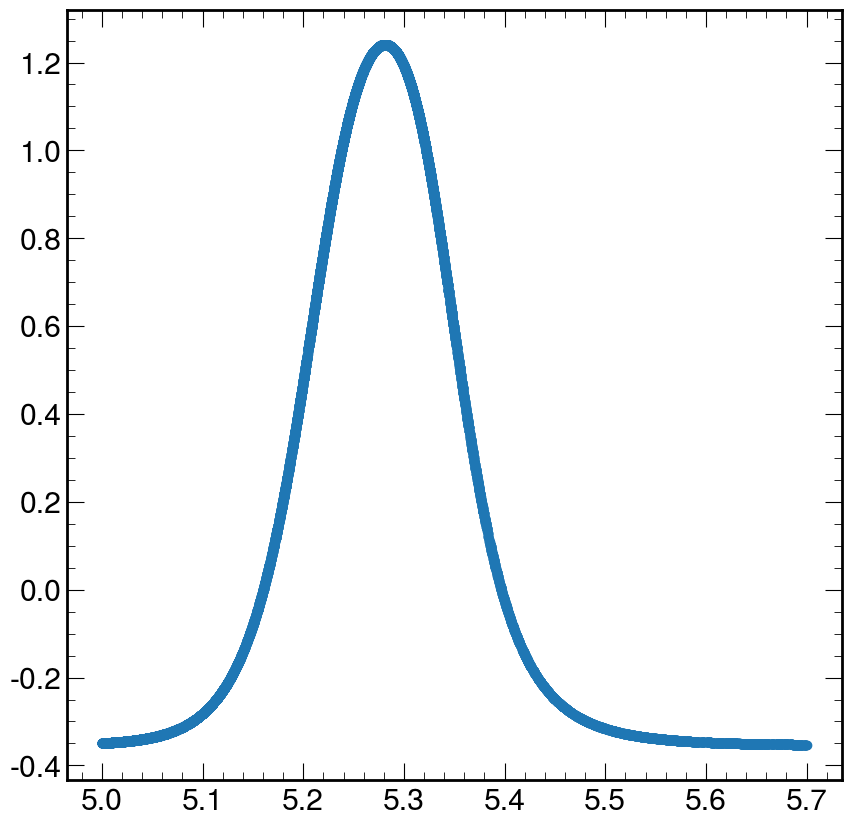

In [13]:
plt.scatter(RD.BMass, RD.sW)

xgb.__version__

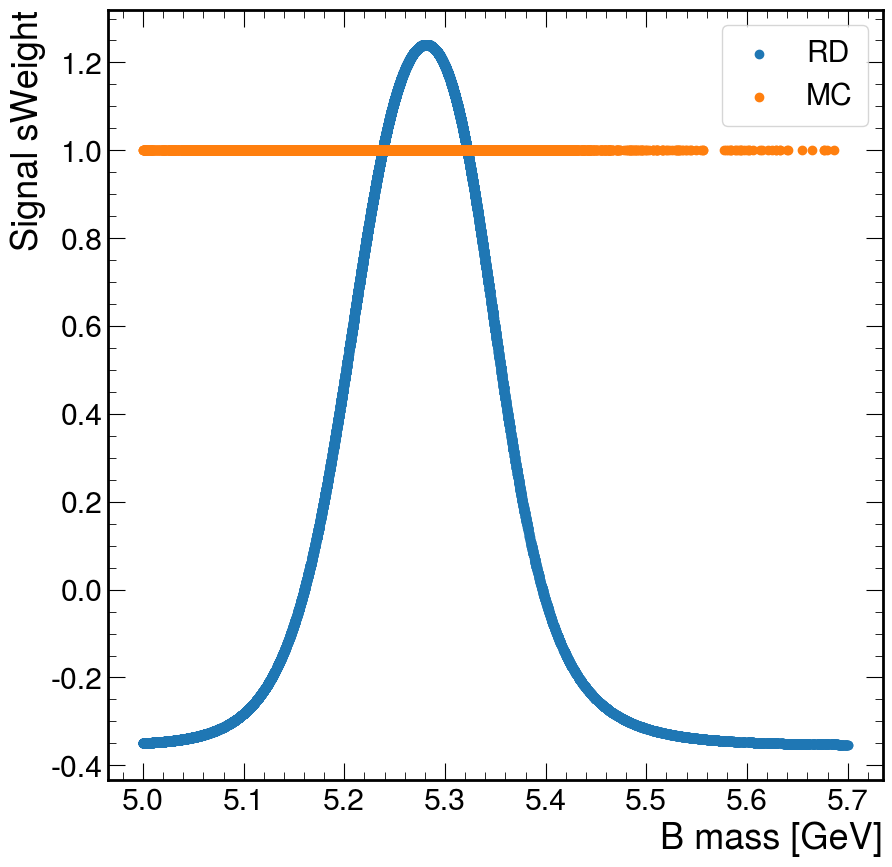

In [14]:
plt.scatter(RD.BMass, RD.sW, label='RD')
plt.scatter(PHSP.BMass, PHSP.sW, label='MC')
plt.xlabel('B mass [GeV]')
plt.ylabel('Signal sWeight')
plt.legend(frameon=True)

# Analysis

## Correlation analysis

In [15]:
RD.columns

Index(['run', 'luminosityBlock', 'event', 'subentry', 'Bpt', 'fit_eta',
       'fit_phi', 'BMass', 'PDL', 'ePDL',
       ...
       'L1_SingleMu12er1p5', 'L1_SingleMu22', 'nPV', 'L_XGB', 'InvMassMissID',
       'LumiMask', 'sW', 'sWFull', 'mll_llfit', 'label'],
      dtype='object', length=119)

In [16]:
PHSP.columns

Index(['run', 'luminosityBlock', 'event', 'subentry', 'Bpt', 'fit_eta',
       'fit_phi', 'BMass', 'PDL', 'ePDL',
       ...
       'L1_SingleMu9er1p5', 'L1_SingleMu10er1p5', 'L1_SingleMu12er1p5',
       'L1_SingleMu22', 'nPV', 'L_XGB', 'InvMassMissID', 'mll_llfit', 'label',
       'sW'],
      dtype='object', length=118)

In [17]:
cols = np.intersect1d(RD.columns, PHSP.columns)

In [18]:
cols

array(['BMass', 'Bpt', 'DiMuMass', 'HLT_DoubleMu4_JpsiTrk_Displaced',
       'HLT_DoubleMu4_LowMassNonResonantTrk_Displaced',
       'HLT_DoubleMu4_PsiPrimeTrk_Displaced', 'HLT_Mu10p5_IP3p5',
       'HLT_Mu12_IP6', 'HLT_Mu7_IP4', 'HLT_Mu8_IP3', 'HLT_Mu8_IP5',
       'HLT_Mu8_IP6', 'HLT_Mu8p5_IP3p5', 'HLT_Mu9_IP4', 'HLT_Mu9_IP5',
       'HLT_Mu9_IP6', 'InvMassMissID', 'L1_SingleMu10er1p5',
       'L1_SingleMu12er1p5', 'L1_SingleMu22', 'L1_SingleMu7er1p5',
       'L1_SingleMu8er1p5', 'L1_SingleMu9er1p5', 'L_XGB',
       'Muon1_HLT_DoubleMu4_JpsiTrk_Displaced',
       'Muon1_HLT_DoubleMu4_LowMassNonResonantTrk_Displaced',
       'Muon1_HLT_DoubleMu4_PsiPrimeTrk_Displaced',
       'Muon1_HLT_Mu10p5_IP3p5', 'Muon1_HLT_Mu12_IP6',
       'Muon1_HLT_Mu7_IP4', 'Muon1_HLT_Mu8_IP3', 'Muon1_HLT_Mu8_IP5',
       'Muon1_HLT_Mu8_IP6', 'Muon1_HLT_Mu8p5_IP3p5', 'Muon1_HLT_Mu9_IP4',
       'Muon1_HLT_Mu9_IP5', 'Muon1_HLT_Mu9_IP6', 'Muon1_isMedium',
       'Muon1_isSoft', 'Muon1_isTracker', 'Muon1_trkKin

In [19]:
for col in cols:
    if len(RD[col].unique()) <= 30:
        cols = np.delete(cols, np.where(cols == col))
cols

array(['BMass', 'Bpt', 'DiMuMass', 'InvMassMissID', 'L_XGB',
       'Muon1_trkKink', 'Muon2_trkKink', 'PDL', 'cosA', 'cosThetaKMu',
       'ePDL', 'event', 'fit_cos2D', 'fit_eta', 'fit_k_eta', 'fit_k_phi',
       'fit_l1_eta', 'fit_l1_phi', 'fit_l2_eta', 'fit_l2_phi', 'fit_phi',
       'kIdx', 'k_DCASig', 'k_dxy', 'k_dxyS', 'k_min_dr_trk_muon',
       'k_min_pt_trk_muon', 'kpt', 'l1pt', 'l2pt', 'luminosityBlock',
       'lxyz_significance', 'mllErr_llfit', 'mll_llfit', 'mll_pt',
       'mu1_IP_sig', 'mu1_eta', 'mu1_pt', 'mu2_IP_sig', 'mu2_eta',
       'mu2_pt', 'nPV', 'prob', 'pv_dz_trgmuon', 'run', 'sW', 'signLxy'],
      dtype=object)

In [20]:
# Analysing the data type of each column, we drop the ones that are not a number

RD_temp = RD.dropna(axis=1, how='all')
PHSP_temp = PHSP.dropna(axis=1, how='all')

In [21]:
cols = np.intersect1d(RD_temp.columns, PHSP_temp.columns)
cols

array(['BMass', 'Bpt', 'DiMuMass', 'HLT_DoubleMu4_JpsiTrk_Displaced',
       'HLT_DoubleMu4_LowMassNonResonantTrk_Displaced',
       'HLT_DoubleMu4_PsiPrimeTrk_Displaced', 'HLT_Mu10p5_IP3p5',
       'HLT_Mu12_IP6', 'HLT_Mu7_IP4', 'HLT_Mu8_IP3', 'HLT_Mu8_IP5',
       'HLT_Mu8_IP6', 'HLT_Mu8p5_IP3p5', 'HLT_Mu9_IP4', 'HLT_Mu9_IP5',
       'HLT_Mu9_IP6', 'InvMassMissID', 'L1_SingleMu10er1p5',
       'L1_SingleMu12er1p5', 'L1_SingleMu22', 'L1_SingleMu7er1p5',
       'L1_SingleMu8er1p5', 'L1_SingleMu9er1p5', 'L_XGB',
       'Muon1_HLT_DoubleMu4_JpsiTrk_Displaced',
       'Muon1_HLT_DoubleMu4_LowMassNonResonantTrk_Displaced',
       'Muon1_HLT_DoubleMu4_PsiPrimeTrk_Displaced',
       'Muon1_HLT_Mu10p5_IP3p5', 'Muon1_HLT_Mu12_IP6',
       'Muon1_HLT_Mu7_IP4', 'Muon1_HLT_Mu8_IP3', 'Muon1_HLT_Mu8_IP5',
       'Muon1_HLT_Mu8_IP6', 'Muon1_HLT_Mu8p5_IP3p5', 'Muon1_HLT_Mu9_IP4',
       'Muon1_HLT_Mu9_IP5', 'Muon1_HLT_Mu9_IP6', 'Muon1_isMedium',
       'Muon1_isSoft', 'Muon1_isTracker', 'Muon1_trkKin

In [22]:
correlations_RD = RD[cols].corr()
correlations_RD

BMass       Bpt  DiMuMass  \
BMass                                          1.000000 -0.035531 -0.015394   
Bpt                                           -0.035531  1.000000 -0.078906   
DiMuMass                                      -0.015394 -0.078906  1.000000   
HLT_DoubleMu4_JpsiTrk_Displaced               -0.028649  0.028155  0.001070   
HLT_DoubleMu4_LowMassNonResonantTrk_Displaced -0.005204  0.100275 -0.332234   
...                                                 ...       ...       ...   
pv_index                                       0.005696 -0.098147 -0.015284   
run                                            0.013391 -0.025331 -0.007506   
sW                                             0.300330  0.056287 -0.038521   
signLxy                                       -0.076783  0.230768 -0.058909   
subentry                                       0.047039 -0.077687  0.125966   

                                               HLT_DoubleMu4_JpsiTrk_Displaced  \
BMass                                                                -0.028649   
Bpt                                                                   0.028155   
DiMuMass                                                              0.001070   
HLT_DoubleMu4_JpsiTrk_Displaced                                       1.000000   
HLT_DoubleMu4_LowMassNonResonantTrk_Displaced                        -0.071468   
...                                                                        ...   
pv_index                                                             -0.017874   
run                                                                  -0.007265   
sW                                                                   -0.020658   
signLxy                                                               0.036925   
subentry                                                             -0.017857   

                                               HLT_DoubleMu4_LowMassNonResonantTrk_Displaced  \
BMass                                                                              -0.005204   
Bpt                                                                                 0.100275   
DiMuMass                                                                           -0.332234   
HLT_DoubleMu4_JpsiTrk_Displaced                                                    -0.071468   
HLT_DoubleMu4_LowMassNonResonantTrk_Displaced                                       1.000000   
...                                                                                      ...   
pv_index                                                                           -0.018128   
run                                                                                -0.003686   
sW                                                                                  0.037772   
signLxy                                                                             0.037769   
subentry                                                                           -0.048236   

                                               HLT_DoubleMu4_PsiPrimeTrk_Displaced  \
BMass                                                                    -0.076409   
Bpt                                                                       0.047700   
DiMuMass                                                                  0.175909   
HLT_DoubleMu4_JpsiTrk_Displaced                                          -0.066998   
HLT_DoubleMu4_LowMassNonResonantTrk_Displaced                            -0.133367   
...                                                                            ...   
pv_index                                                                  0.002493   
run                                                                      -0.006392   
sW                                                                        0.013172   
signLxy                                                                   0.051927   
subentry         

In [23]:
correlations_MC = PHSP[cols].corr()
correlations_MC

BMass       Bpt  DiMuMass  \
BMass                                          1.000000  0.004379  0.026490   
Bpt                                            0.004379  1.000000 -0.124907   
DiMuMass                                       0.026490 -0.124907  1.000000   
HLT_DoubleMu4_JpsiTrk_Displaced               -0.006595  0.018823  0.018026   
HLT_DoubleMu4_LowMassNonResonantTrk_Displaced -0.010995  0.149748 -0.321700   
...                                                 ...       ...       ...   
pv_index                                       0.007925 -0.161478  0.054521   
run                                                 NaN       NaN       NaN   
sW                                                  NaN       NaN       NaN   
signLxy                                       -0.007465  0.202483 -0.036576   
subentry                                       0.000142 -0.033188  0.030261   

                                               HLT_DoubleMu4_JpsiTrk_Displaced  \
BMass                                                                -0.006595   
Bpt                                                                   0.018823   
DiMuMass                                                              0.018026   
HLT_DoubleMu4_JpsiTrk_Displaced                                       1.000000   
HLT_DoubleMu4_LowMassNonResonantTrk_Displaced                        -0.060531   
...                                                                        ...   
pv_index                                                             -0.010528   
run                                                                        NaN   
sW                                                                         NaN   
signLxy                                                               0.004518   
subentry                                                             -0.002023   

                                               HLT_DoubleMu4_LowMassNonResonantTrk_Displaced  \
BMass                                                                              -0.010995   
Bpt                                                                                 0.149748   
DiMuMass                                                                           -0.321700   
HLT_DoubleMu4_JpsiTrk_Displaced                                                    -0.060531   
HLT_DoubleMu4_LowMassNonResonantTrk_Displaced                                       1.000000   
...                                                                                      ...   
pv_index                                                                           -0.045151   
run                                                                                      NaN   
sW                                                                                       NaN   
signLxy                                                                             0.048955   
subentry                                                                           -0.018163   

                                               HLT_DoubleMu4_PsiPrimeTrk_Displaced  \
BMass                                                                     0.003603   
Bpt                                                                       0.023148   
DiMuMass                                                                  0.221186   
HLT_DoubleMu4_JpsiTrk_Displaced                                          -0.051025   
HLT_DoubleMu4_LowMassNonResonantTrk_Displaced                            -0.156348   
...                                                                            ...   
pv_index                                                                  0.002213   
run                                                                            NaN   
sW                                                                             NaN   
signLxy                                                                   0.019190   
subentry         

In [24]:
correlations_RD.dropna(how='all', inplace=True)
correlations_RD.dropna(how='all', inplace=True, axis=1)
correlations_MC.dropna(how='all', inplace=True)
correlations_MC.dropna(how='all', inplace=True, axis=1)

In [25]:
correlations_RD

BMass       Bpt  DiMuMass  \
BMass                                          1.000000 -0.035531 -0.015394   
Bpt                                           -0.035531  1.000000 -0.078906   
DiMuMass                                      -0.015394 -0.078906  1.000000   
HLT_DoubleMu4_JpsiTrk_Displaced               -0.028649  0.028155  0.001070   
HLT_DoubleMu4_LowMassNonResonantTrk_Displaced -0.005204  0.100275 -0.332234   
...                                                 ...       ...       ...   
pv_index                                       0.005696 -0.098147 -0.015284   
run                                            0.013391 -0.025331 -0.007506   
sW                                             0.300330  0.056287 -0.038521   
signLxy                                       -0.076783  0.230768 -0.058909   
subentry                                       0.047039 -0.077687  0.125966   

                                               HLT_DoubleMu4_JpsiTrk_Displaced  \
BMass                                                                -0.028649   
Bpt                                                                   0.028155   
DiMuMass                                                              0.001070   
HLT_DoubleMu4_JpsiTrk_Displaced                                       1.000000   
HLT_DoubleMu4_LowMassNonResonantTrk_Displaced                        -0.071468   
...                                                                        ...   
pv_index                                                             -0.017874   
run                                                                  -0.007265   
sW                                                                   -0.020658   
signLxy                                                               0.036925   
subentry                                                             -0.017857   

                                               HLT_DoubleMu4_LowMassNonResonantTrk_Displaced  \
BMass                                                                              -0.005204   
Bpt                                                                                 0.100275   
DiMuMass                                                                           -0.332234   
HLT_DoubleMu4_JpsiTrk_Displaced                                                    -0.071468   
HLT_DoubleMu4_LowMassNonResonantTrk_Displaced                                       1.000000   
...                                                                                      ...   
pv_index                                                                           -0.018128   
run                                                                                -0.003686   
sW                                                                                  0.037772   
signLxy                                                                             0.037769   
subentry                                                                           -0.048236   

                                               HLT_DoubleMu4_PsiPrimeTrk_Displaced  \
BMass                                                                    -0.076409   
Bpt                                                                       0.047700   
DiMuMass                                                                  0.175909   
HLT_DoubleMu4_JpsiTrk_Displaced                                          -0.066998   
HLT_DoubleMu4_LowMassNonResonantTrk_Displaced                            -0.133367   
...                                                                            ...   
pv_index                                                                  0.002493   
run                                                                      -0.006392   
sW                                                                        0.013172   
signLxy                                                                   0.051927   
subentry         

In [26]:
correlations_MC

BMass       Bpt  DiMuMass  \
BMass                                          1.000000  0.004379  0.026490   
Bpt                                            0.004379  1.000000 -0.124907   
DiMuMass                                       0.026490 -0.124907  1.000000   
HLT_DoubleMu4_JpsiTrk_Displaced               -0.006595  0.018823  0.018026   
HLT_DoubleMu4_LowMassNonResonantTrk_Displaced -0.010995  0.149748 -0.321700   
...                                                 ...       ...       ...   
prob                                          -0.004562 -0.061998  0.025098   
pv_dz_trgmuon                                 -0.005495  0.016995  0.082961   
pv_index                                       0.007925 -0.161478  0.054521   
signLxy                                       -0.007465  0.202483 -0.036576   
subentry                                       0.000142 -0.033188  0.030261   

                                               HLT_DoubleMu4_JpsiTrk_Displaced  \
BMass                                                                -0.006595   
Bpt                                                                   0.018823   
DiMuMass                                                              0.018026   
HLT_DoubleMu4_JpsiTrk_Displaced                                       1.000000   
HLT_DoubleMu4_LowMassNonResonantTrk_Displaced                        -0.060531   
...                                                                        ...   
prob                                                                  0.011081   
pv_dz_trgmuon                                                        -0.015890   
pv_index                                                             -0.010528   
signLxy                                                               0.004518   
subentry                                                             -0.002023   

                                               HLT_DoubleMu4_LowMassNonResonantTrk_Displaced  \
BMass                                                                              -0.010995   
Bpt                                                                                 0.149748   
DiMuMass                                                                           -0.321700   
HLT_DoubleMu4_JpsiTrk_Displaced                                                    -0.060531   
HLT_DoubleMu4_LowMassNonResonantTrk_Displaced                                       1.000000   
...                                                                                      ...   
prob                                                                                0.019900   
pv_dz_trgmuon                                                                      -0.032572   
pv_index                                                                           -0.045151   
signLxy                                                                             0.048955   
subentry                                                                           -0.018163   

                                               HLT_DoubleMu4_PsiPrimeTrk_Displaced  \
BMass                                                                     0.003603   
Bpt                                                                       0.023148   
DiMuMass                                                                  0.221186   
HLT_DoubleMu4_JpsiTrk_Displaced                                          -0.051025   
HLT_DoubleMu4_LowMassNonResonantTrk_Displaced                            -0.156348   
...                                                                            ...   
prob                                                                      0.025232   
pv_dz_trgmuon                                                             0.021968   
pv_index                                                                  0.002213   
signLxy                                                                   0.019190   
subentry         

In [27]:
cols = np.intersect1d(correlations_MC.columns, correlations_RD.columns)
cols

array(['BMass', 'Bpt', 'DiMuMass', 'HLT_DoubleMu4_JpsiTrk_Displaced',
       'HLT_DoubleMu4_LowMassNonResonantTrk_Displaced',
       'HLT_DoubleMu4_PsiPrimeTrk_Displaced', 'HLT_Mu12_IP6',
       'HLT_Mu7_IP4', 'HLT_Mu8_IP3', 'HLT_Mu8_IP5', 'HLT_Mu8_IP6',
       'HLT_Mu9_IP5', 'HLT_Mu9_IP6', 'InvMassMissID',
       'L1_SingleMu10er1p5', 'L1_SingleMu12er1p5', 'L1_SingleMu22',
       'L1_SingleMu7er1p5', 'L1_SingleMu8er1p5', 'L1_SingleMu9er1p5',
       'L_XGB', 'Muon1_HLT_DoubleMu4_JpsiTrk_Displaced',
       'Muon1_HLT_DoubleMu4_LowMassNonResonantTrk_Displaced',
       'Muon1_HLT_DoubleMu4_PsiPrimeTrk_Displaced', 'Muon1_HLT_Mu12_IP6',
       'Muon1_HLT_Mu7_IP4', 'Muon1_HLT_Mu8_IP3', 'Muon1_HLT_Mu8_IP5',
       'Muon1_HLT_Mu8_IP6', 'Muon1_HLT_Mu9_IP5', 'Muon1_HLT_Mu9_IP6',
       'Muon1_isSoft', 'Muon1_trkKink',
       'Muon2_HLT_DoubleMu4_JpsiTrk_Displaced',
       'Muon2_HLT_DoubleMu4_LowMassNonResonantTrk_Displaced',
       'Muon2_HLT_DoubleMu4_PsiPrimeTrk_Displaced', 'Muon2_HLT_Mu12_IP

In [28]:
corr_cols = []
iter_cols = cols
for index, row in correlations_MC.iterrows():
    for col in iter_cols:
        # Selecting the single row
        if (row[col] > 0.9 and index != col):
            print("Index", index, "col", col, "val", row[col])
            corr_cols.append(index)
    iter_cols = np.delete(iter_cols, np.where(iter_cols == index))
print(corr_cols)

Index DiMuMass col mll_llfit val 0.9999917378662131
Index HLT_DoubleMu4_JpsiTrk_Displaced col Muon1_HLT_DoubleMu4_JpsiTrk_Displaced val 0.999565551347465
Index HLT_DoubleMu4_JpsiTrk_Displaced col Muon2_HLT_DoubleMu4_JpsiTrk_Displaced val 0.9991309285085653
Index HLT_DoubleMu4_LowMassNonResonantTrk_Displaced col Muon1_HLT_DoubleMu4_LowMassNonResonantTrk_Displaced val 0.9998104452146969
Index HLT_DoubleMu4_LowMassNonResonantTrk_Displaced col Muon2_HLT_DoubleMu4_LowMassNonResonantTrk_Displaced val 0.9997472572699864
Index HLT_DoubleMu4_PsiPrimeTrk_Displaced col Muon1_HLT_DoubleMu4_PsiPrimeTrk_Displaced val 1.0
Index HLT_DoubleMu4_PsiPrimeTrk_Displaced col Muon2_HLT_DoubleMu4_PsiPrimeTrk_Displaced val 1.0
Index HLT_Mu12_IP6 col Muon1_HLT_Mu12_IP6 val 0.9737100259864389
Index HLT_Mu8_IP5 col Muon1_HLT_Mu8_IP5 val 0.9012814063843427
Index HLT_Mu8_IP6 col Muon1_HLT_Mu8_IP6 val 0.9057138833222987
Index HLT_Mu9_IP4 col HLT_Mu9_IP5 val 0.9171661258289125
Index HLT_Mu9_IP5 col HLT_Mu9_IP6 val 0.9

In [29]:
cols = np.setdiff1d(cols, corr_cols)
cols

array(['BMass', 'Bpt', 'HLT_Mu7_IP4', 'HLT_Mu8_IP3', 'InvMassMissID',
       'L1_SingleMu10er1p5', 'L1_SingleMu12er1p5', 'L1_SingleMu22',
       'L1_SingleMu7er1p5', 'L1_SingleMu8er1p5', 'L1_SingleMu9er1p5',
       'L_XGB', 'Muon1_HLT_Mu12_IP6', 'Muon1_HLT_Mu7_IP4',
       'Muon1_HLT_Mu8_IP3', 'Muon1_HLT_Mu8_IP5', 'Muon1_HLT_Mu8_IP6',
       'Muon1_HLT_Mu9_IP6', 'Muon1_trkKink',
       'Muon2_HLT_DoubleMu4_JpsiTrk_Displaced',
       'Muon2_HLT_DoubleMu4_LowMassNonResonantTrk_Displaced',
       'Muon2_HLT_DoubleMu4_PsiPrimeTrk_Displaced', 'Muon2_HLT_Mu12_IP6',
       'Muon2_HLT_Mu8_IP6', 'Muon2_HLT_Mu9_IP6', 'Muon2_isTracker',
       'Muon2_trkKink', 'PDL', 'cosA', 'cosThetaKMu', 'ePDL', 'fit_cos2D',
       'fit_k_phi', 'fit_l1_phi', 'fit_l2_phi', 'fit_phi', 'kIdx',
       'k_DCASig', 'k_charge', 'k_dxyS', 'k_lostInnerHits', 'k_matchMuon',
       'k_min_dr_trk_muon', 'k_min_pt_trk_muon', 'k_numberOfHits',
       'k_numberOfPixelHits', 'kpt', 'l1_charge', 'l2_charge',
       'luminosityB

In [30]:
len(cols)

67

In [31]:
cols = cols.tolist()

Based just in plots, we decide to delete the following columns:
- L1_*
- HLT_*
- Muon1_* (Muon1_trkKink)
- Muon2_* (Muon2_trkKink)
- k_charge


In [32]:
cols = [ x for x in cols if "L1_" not in x ]
cols = [ x for x in cols if "HLT_" not in x ]
cols = [ x for x in cols if "Muon1_" not in x ]
cols = [ x for x in cols if "Muon2_" not in x ]
cols = [ x for x in cols if "k_charge" not in x ]
cols

['BMass',
 'Bpt',
 'InvMassMissID',
 'L_XGB',
 'PDL',
 'cosA',
 'cosThetaKMu',
 'ePDL',
 'fit_cos2D',
 'fit_k_phi',
 'fit_l1_phi',
 'fit_l2_phi',
 'fit_phi',
 'kIdx',
 'k_DCASig',
 'k_dxyS',
 'k_lostInnerHits',
 'k_matchMuon',
 'k_min_dr_trk_muon',
 'k_min_pt_trk_muon',
 'k_numberOfHits',
 'k_numberOfPixelHits',
 'kpt',
 'l1_charge',
 'l2_charge',
 'luminosityBlock',
 'mllErr_llfit',
 'mll_llfit',
 'mu1_IP_sig',
 'mu1_isSoft',
 'mu1_isTriggering',
 'mu1_pt',
 'mu2_IP_sig',
 'mu2_eta',
 'mu2_isSoft',
 'mu2_isTriggering',
 'mu2_pt',
 'nPV',
 'prob',
 'pv_dz_trgmuon',
 'pv_index',
 'signLxy',
 'subentry']

We delete a subset of columns that are not useful for analysis by viewing the distributions generated in the histograms below
- k_lostInnerHits
- k_matchMuon
- k_numberOfPixelHits
- l1_charge
- l2_charge
- mu1_isSoft
- mu2_isSoft
- mu1_isTriggering
- mu2_isTriggering
- subentry

In [33]:
del_cols = ["k_lostInnerHits",
"k_matchMuon",
"k_numberOfPixelHits",
"l1_charge",
"l2_charge",
"mu1_isSoft",
"mu2_isSoft",
"mu1_isTriggering",
"mu2_isTriggering",
"subentry"]
for del_col in del_cols:
    cols.remove(del_col)
cols

['BMass',
 'Bpt',
 'InvMassMissID',
 'L_XGB',
 'PDL',
 'cosA',
 'cosThetaKMu',
 'ePDL',
 'fit_cos2D',
 'fit_k_phi',
 'fit_l1_phi',
 'fit_l2_phi',
 'fit_phi',
 'kIdx',
 'k_DCASig',
 'k_dxyS',
 'k_min_dr_trk_muon',
 'k_min_pt_trk_muon',
 'k_numberOfHits',
 'kpt',
 'luminosityBlock',
 'mllErr_llfit',
 'mll_llfit',
 'mu1_IP_sig',
 'mu1_pt',
 'mu2_IP_sig',
 'mu2_eta',
 'mu2_pt',
 'nPV',
 'prob',
 'pv_dz_trgmuon',
 'pv_index',
 'signLxy']

## Feature analysis using SHAP

In [34]:
PHSP[cols+ ['label', 'sW']].head()

BMass        Bpt  InvMassMissID     L_XGB       PDL      cosA  \
0  5.285251  28.839212       4.770353  0.995725  0.041537  0.999998   
1  5.270722  24.970198       2.029543  0.992940  0.348711  1.000000   
2  5.251672  39.500355       1.864256  0.985609  0.030079  0.999994   
3  5.321138  16.659063       4.271185  0.979111  0.033030  0.999373   
4  5.214650  20.810635       3.346152  0.989596  0.138654  0.999955   

   cosThetaKMu      ePDL  fit_cos2D  fit_k_phi  ...  mu2_IP_sig   mu2_eta  \
0    -0.735924  0.001039   0.999999  -0.472634  ...    0.099529 -0.626398   
1     0.457132  0.000967   1.000000  -0.009666  ...  180.117020 -1.488520   
2     0.212882  0.000858   0.999987   2.657161  ...    3.458688  0.961464   
3    -0.424868  0.002083   0.999963  -2.197967  ...    6.465394  0.741684   
4    -0.921808  0.001312   0.999995  -2.529192  ...   30.989592  0.273229   

      mu2_pt  nPV      prob  pv_dz_trgmuon  pv_index     signLxy  label  sW  
0   4.434833   22  0.555448       0.036163         0   31.438383      0   1  
1   4.689808   20  0.015591       0.238163         0  360.225100      0   1  
2  16.069603   10  0.547768       0.030696         0   26.461100      0   1  
3   3.591469   13  0.858356       0.003811         0   15.773618      0   1  
4   6.500200   21  0.802490       0.149731         0   87.646130      0   1  

[5 rows x 35 columns]

In [35]:
RD[cols].head()

BMass        Bpt  InvMassMissID     L_XGB       PDL      cosA  \
3  5.690995  33.545640       0.714522  0.987169  0.052340  0.999935   
5  5.316479  16.960064       2.495088  0.995206  0.124445  0.999994   
6  5.320261  27.350239       3.638453  0.990032  0.048305  0.999991   
8  5.088193  21.659235       1.619849  0.991862  0.054452  0.999862   
9  5.019077  16.756233       1.334363  0.984711  0.129470  0.999943   

   cosThetaKMu      ePDL  fit_cos2D  fit_k_phi  ...  mu1_IP_sig     mu1_pt  \
3     0.899938  0.000907   1.000000   0.605412  ...   11.442237  19.407322   
5    -0.143563  0.001282   0.999998  -2.282695  ...   50.452198   9.144328   
6    -0.141988  0.001320   0.999983  -2.517219  ...    1.073167  13.614323   
8     0.334081  0.001725   0.999983  -1.753845  ...   12.293502  10.850794   
9     0.204931  0.001359   0.999998   2.421297  ...    7.062680   9.721932   

   mu2_IP_sig   mu2_eta     mu2_pt  nPV      prob  pv_dz_trgmuon  pv_index  \
3   39.802177 -0.424483   6.270134   25  0.101036       0.000433         0   
5   56.915810 -1.292956   3.610502   25  0.263458       0.061823         6   
6   13.549708  1.598661  11.508586   22  0.495358       0.057248         0   
8   16.582699  0.040687   5.897513   25  0.587679       0.037460         0   
9    5.358078 -1.296278   4.026424   18  0.731351       0.116391         4   

     signLxy  
3  45.528965  
5  80.418590  
6  35.803524  
8  30.252410  
9  72.296080  

[5 rows x 33 columns]

# Model fit and training

In [67]:
cols = ['Bpt',
 'PDL',
 'cosA',
 'fit_eta',
 'kpt',
 'l1pt',
 'l2pt',
 'mu1_IP_sig',
 'mu2_IP_sig',
 'prob',
 'signLxy']

In [37]:
dataFrame = pd.concat([RD[cols+['label', 'sW']],
                       PHSP[cols+['label', 'sW']]])

In [38]:
param_dict={'objective':'multi:softprob', 'n_estiators':200, 'learning_rate':0.1, 'max_depth':6, 'gamma':  0, 'n_jobs':10, 'num_class':2}
classifier = FastBDT.Classifier()
classifier.fit(X=dataFrame[cols], 
               y=dataFrame.label, 
               weights=dataFrame['sW'] # Weights with negative instances
              )

cols = ['Bpt', 'kpt', 'mu1_pt', 'mu2_pt']
classifier2 = xgb.XGBClassifier()
classifier2.fit(X=dataFrame[cols], 
               y=dataFrame.label, 
               sample_weight=np.where(dataFrame['sW']<0, 0, dataFrame['sW']))

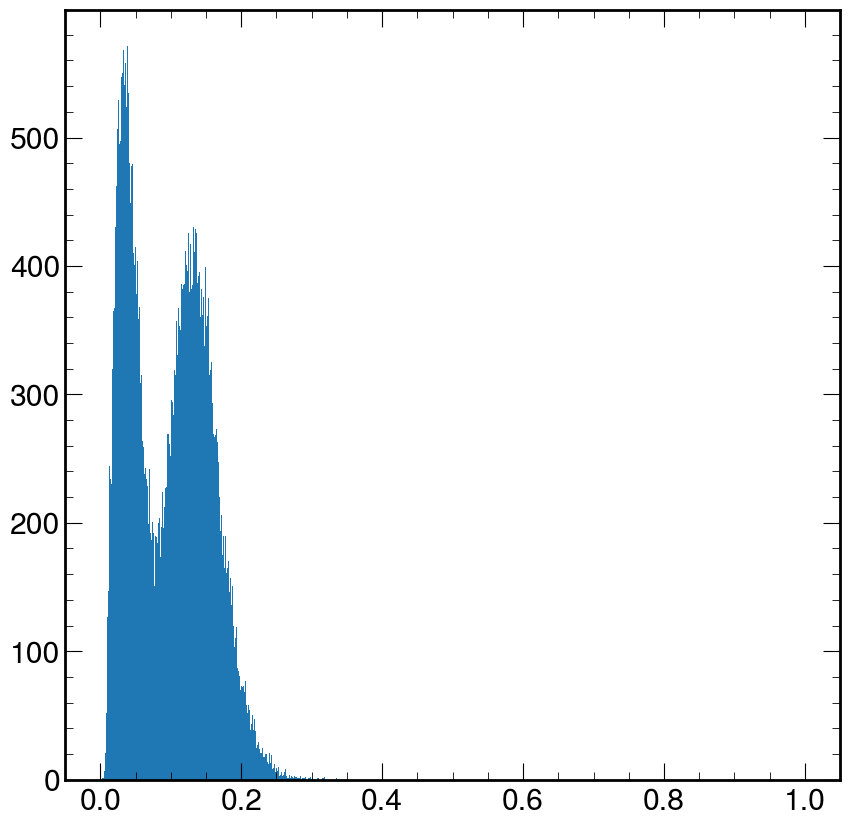

In [39]:
h = plt.hist(classifier.predict(PHSP[cols]), bins=1000, range=[0,1])
#plt.hist(classifier2.predict_proba(PHSP[cols])[:,1], bins=h[1], histtype='step')
plt.show()

prob1 = classifier.predict_proba(PHSP[cols])[:,1]
prob2 = classifier2.predict_proba(PHSP[cols])[:,1]
h = plt.hist(prob1 - prob2, bins=1000, range=[0,1])
plt.show()

In [40]:
new_weights = classifier.predict(PHSP[cols])/(1-classifier.predict(PHSP[cols]))

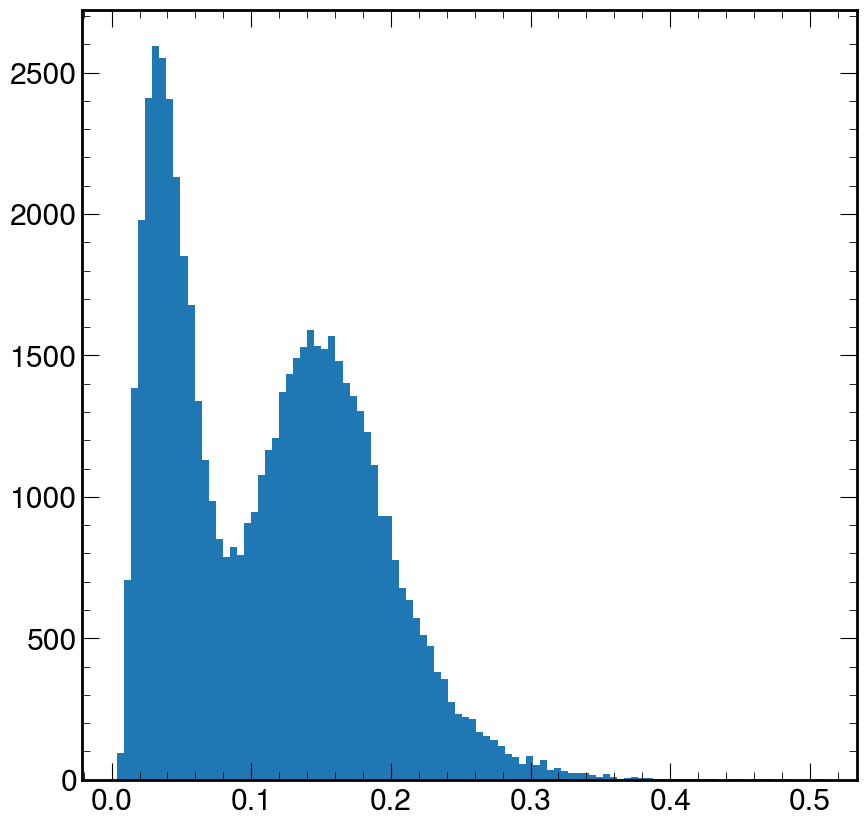

In [41]:
plt.hist(new_weights, bins=100)
plt.show()

In [42]:
cols

['Bpt',
 'PDL',
 'cosA',
 'fit_eta',
 'kpt',
 'l1pt',
 'l2pt',
 'mu1_IP_sig',
 'mu2_IP_sig',
 'prob',
 'signLxy']

Overflow  (>=229.468)
	 1.0 +- 1.0
	Unweighted  1 

Overflow  (>=229.468)
	 0.79 +- 0.79
	Unweighted  1 



./scripts/plot_tools.py:1516: RuntimeWarning: divide by zero encountered in true_divide
  ratio = Histo_Num[0]/Histo_Den[0]
./scripts/plot_tools.py:1516: RuntimeWarning: invalid value encountered in true_divide
  ratio = Histo_Num[0]/Histo_Den[0]
./scripts/plot_tools.py:1519: RuntimeWarning: invalid value encountered in true_divide
  error = ratio*np.hypot(Histo_Num[-1]/Histo_Num[0], Histo_Den[-1]/Histo_Den[0])


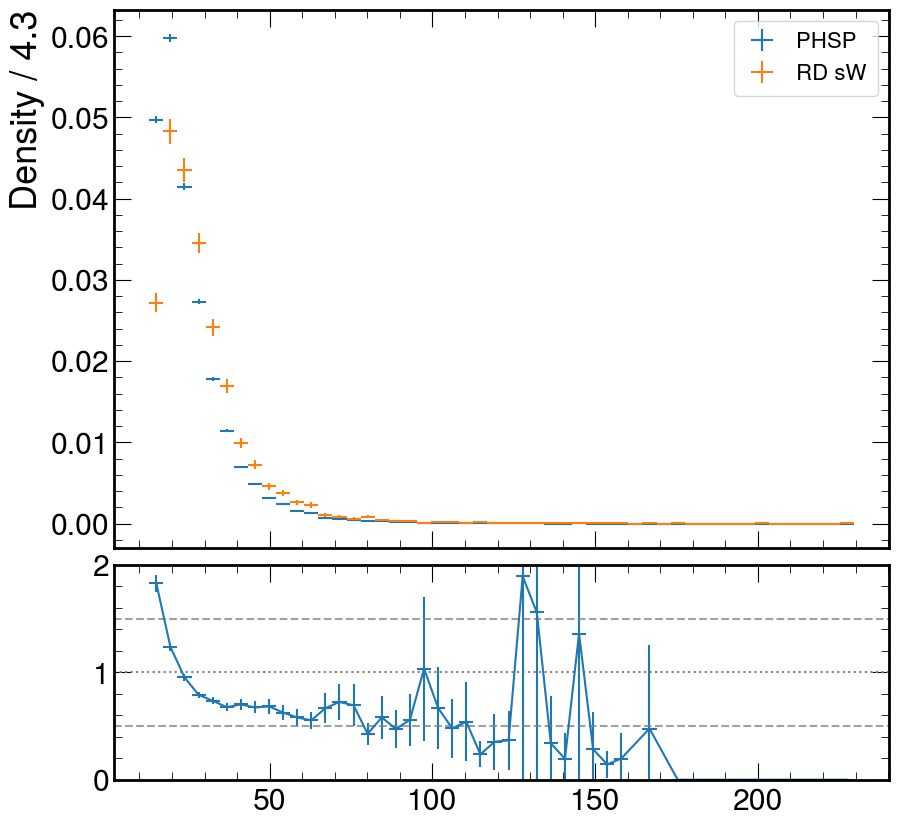

In [43]:
var = cols[0]
plot_tools.compare_plot(PHSP[var], 
                        RD[var], 
                        weights_Den=RD.sW, label_Den='RD sW', label_Num='PHSP')

In [44]:
cols

['Bpt',
 'PDL',
 'cosA',
 'fit_eta',
 'kpt',
 'l1pt',
 'l2pt',
 'mu1_IP_sig',
 'mu2_IP_sig',
 'prob',
 'signLxy']

In [45]:
ranges = {
    'Bpt': [10,150],
    'PDL': [0,0.5],
    'cosA': [0.9990,1],
    'fit_eta':None,
    'kpt':[0,70],
    'l1pt':[5,75],
    'l2pt':[5,40],
    'mu1_IP_sig':[0,150],
    'mu2_IP_sig':[0,150],
    'prob':None,
    'signLxy':[0,400],
}

In [80]:
bins = 50

Overflow  (>=150.0)
	 13.0 +- 3.61
	Unweighted  13 

Overflow  (>=150.0)
	 8.56 +- 3.07
	Unweighted  13 

Overflow  (>=0.5)
	 1.0 +- 1.0
	Unweighted  1 

Underflow (<0.999)
	 206.0 +- 14.35
	Unweighted  206 

Overflow  (>=1.0)
	 234.0 +- 15.3
	Unweighted  234 

Underflow (<0.999)
	 15.8 +- 5.32
	Unweighted  60 

Overflow  (>=1.0)
	 18.29 +- 5.07
	Unweighted  36 

Overflow  (>=2.429)
	 1.0 +- 1.0
	Unweighted  1 

Overflow  (>=2.429)
	 0.97 +- 1.12
	Unweighted  2 

Overflow  (>=70.0)
	 36.0 +- 6.0
	Unweighted  36 

Overflow  (>=70.0)
	 6.43 +- 3.06
	Unweighted  18 

Overflow  (>=75.0)
	 27.0 +- 5.2
	Unweighted  27 

Overflow  (>=75.0)
	 5.34 +- 3.1
	Unweighted  20 

Underflow (<5.0)
	 22391.0 +- 149.64
	Unweighted  22391 

Overflow  (>=40.0)
	 10.0 +- 3.16
	Unweighted  10 

Underflow (<5.0)
	 2276.27 +- 58.98
	Unweighted  5877 

Overflow  (>=40.0)
	 2.64 +- 1.96
	Unweighted  5 

Overflow  (>=150.0)
	 58.0 +- 7.62
	Unweighted  58 

Overflow  (>=150.0)
	 3.15 +- 2.17
	Unweighted  5 

Overf

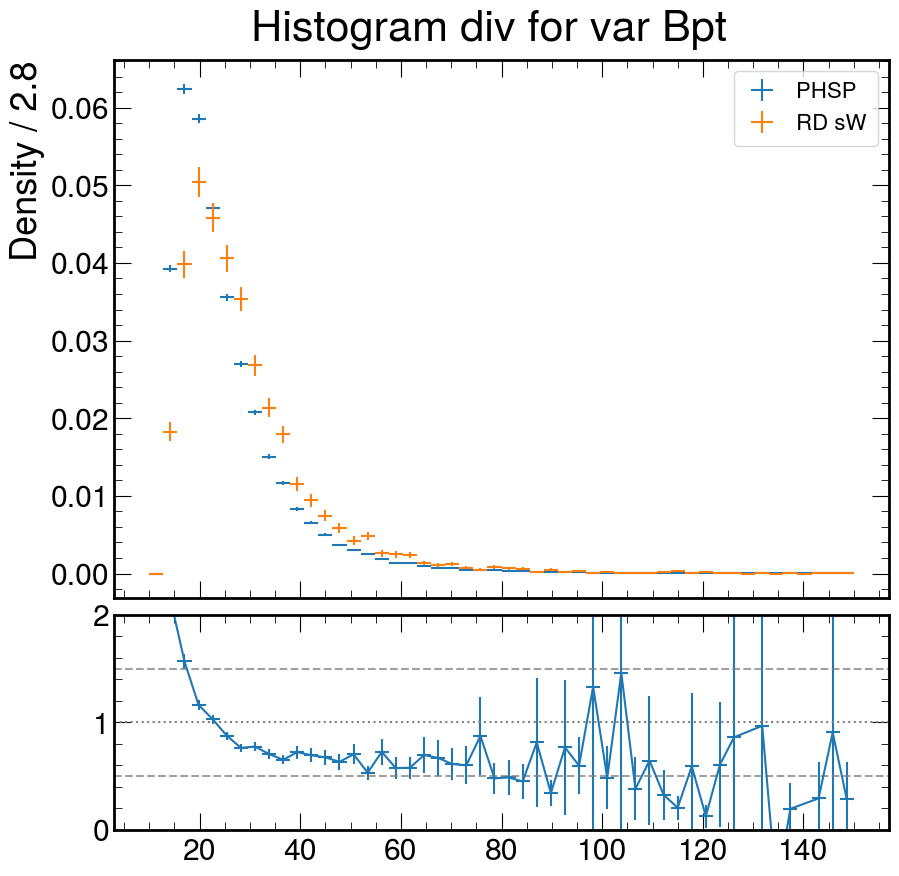

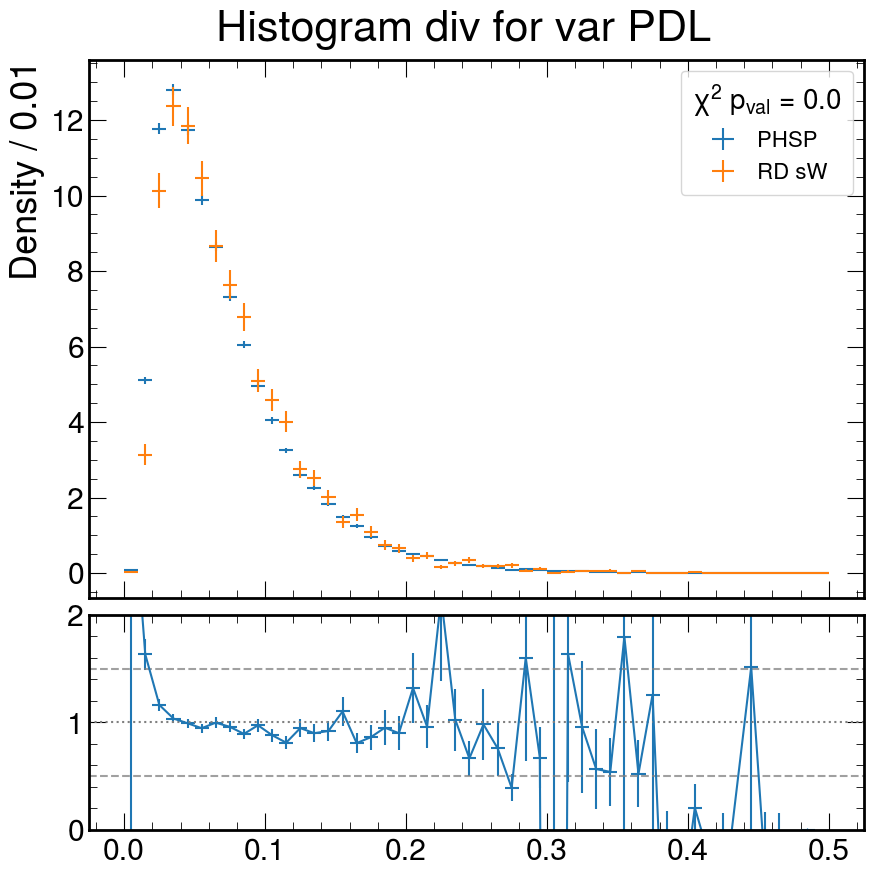

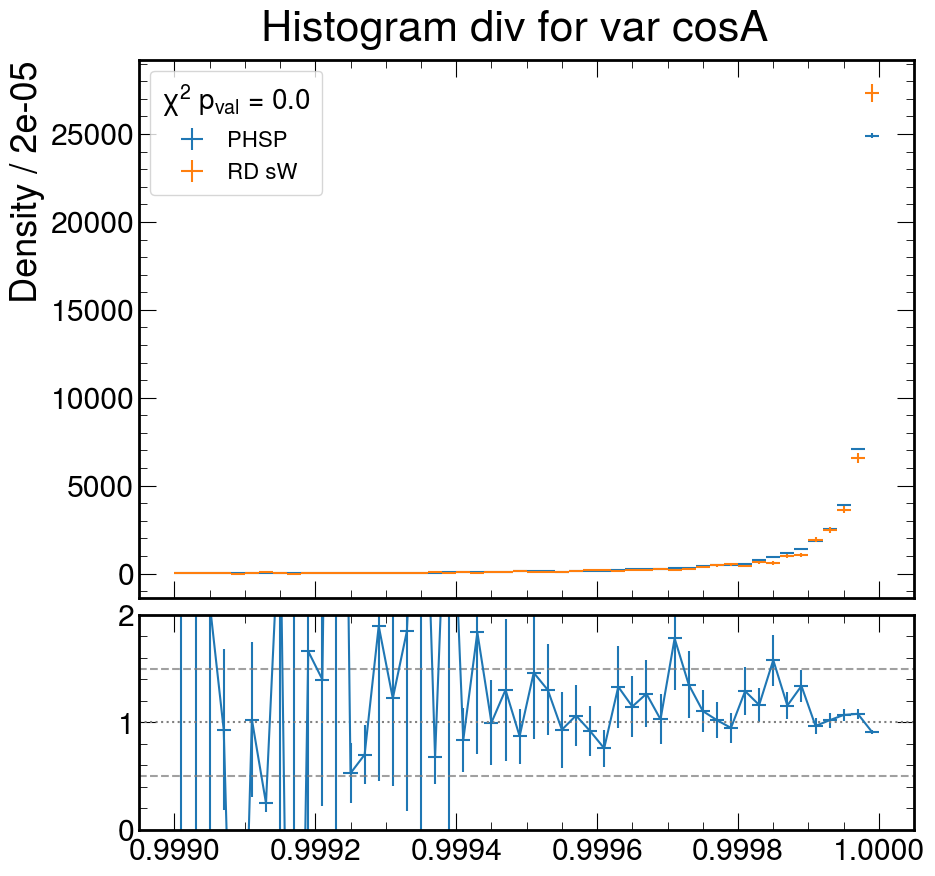

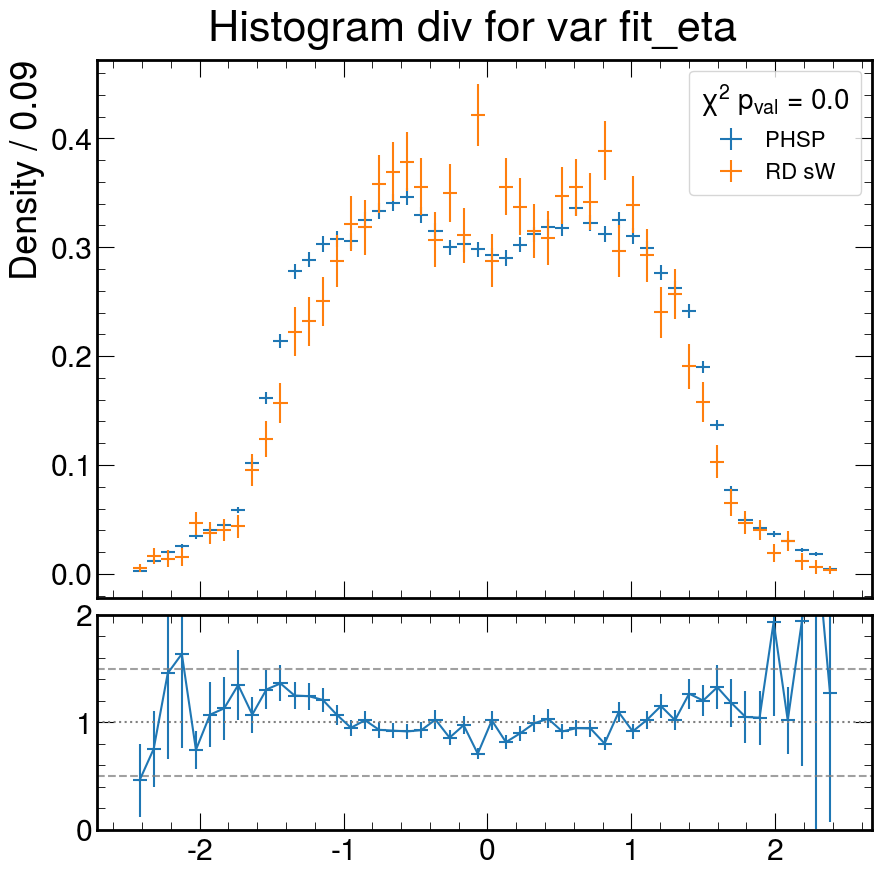

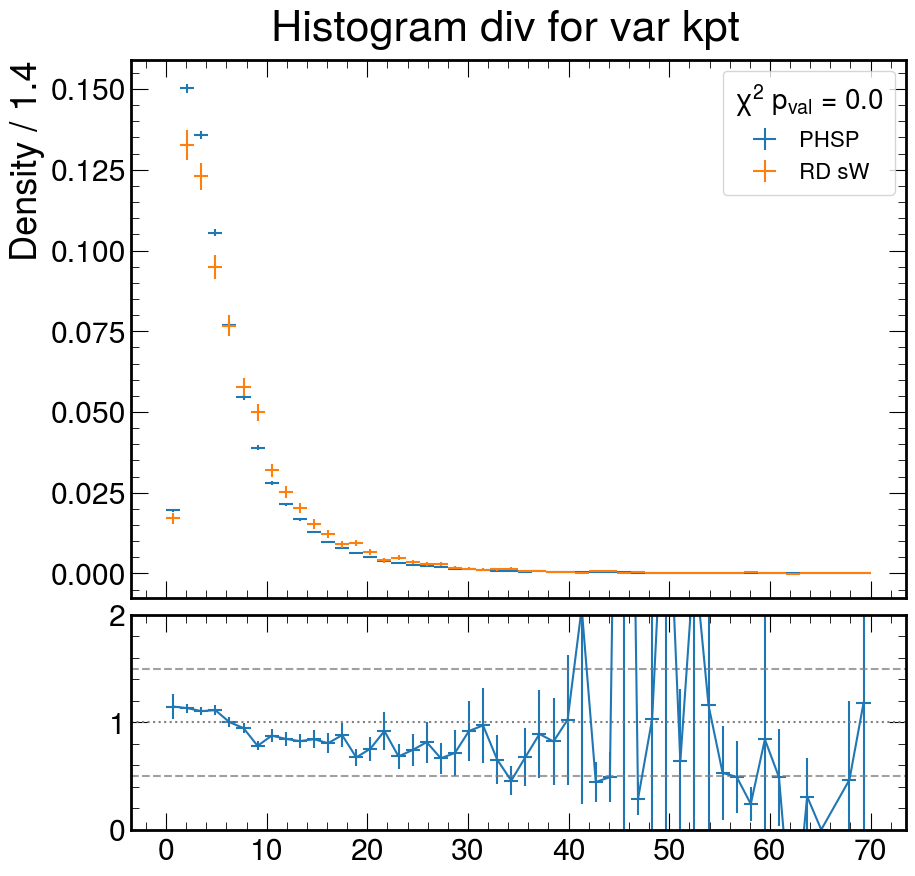

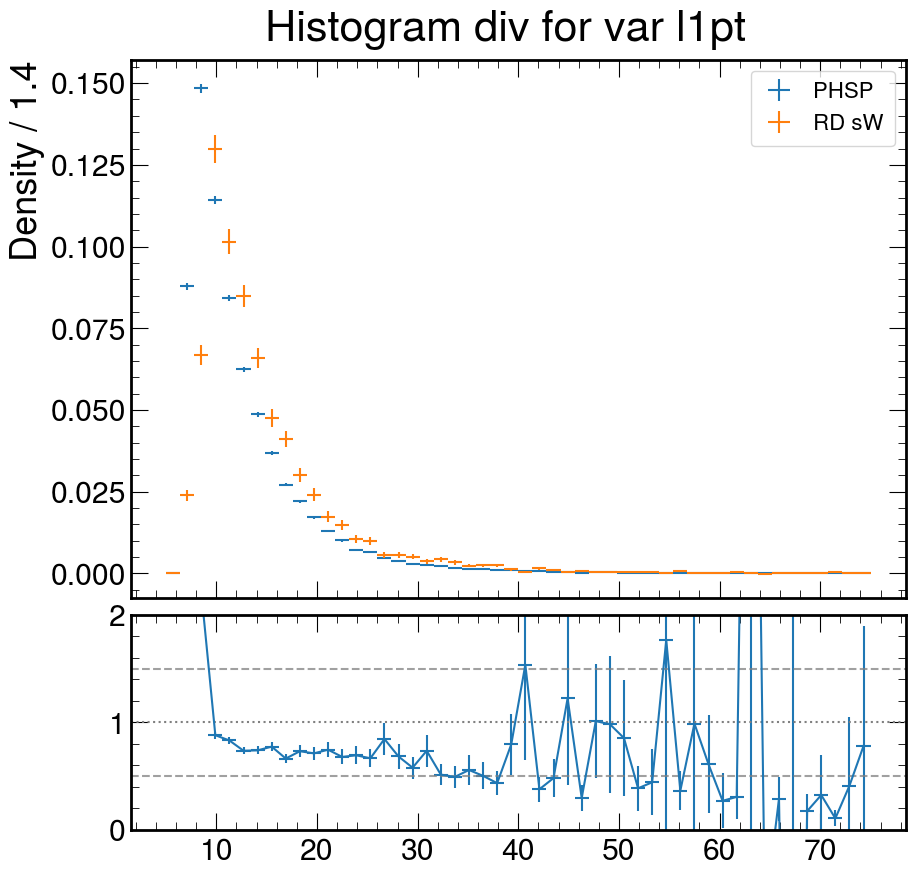

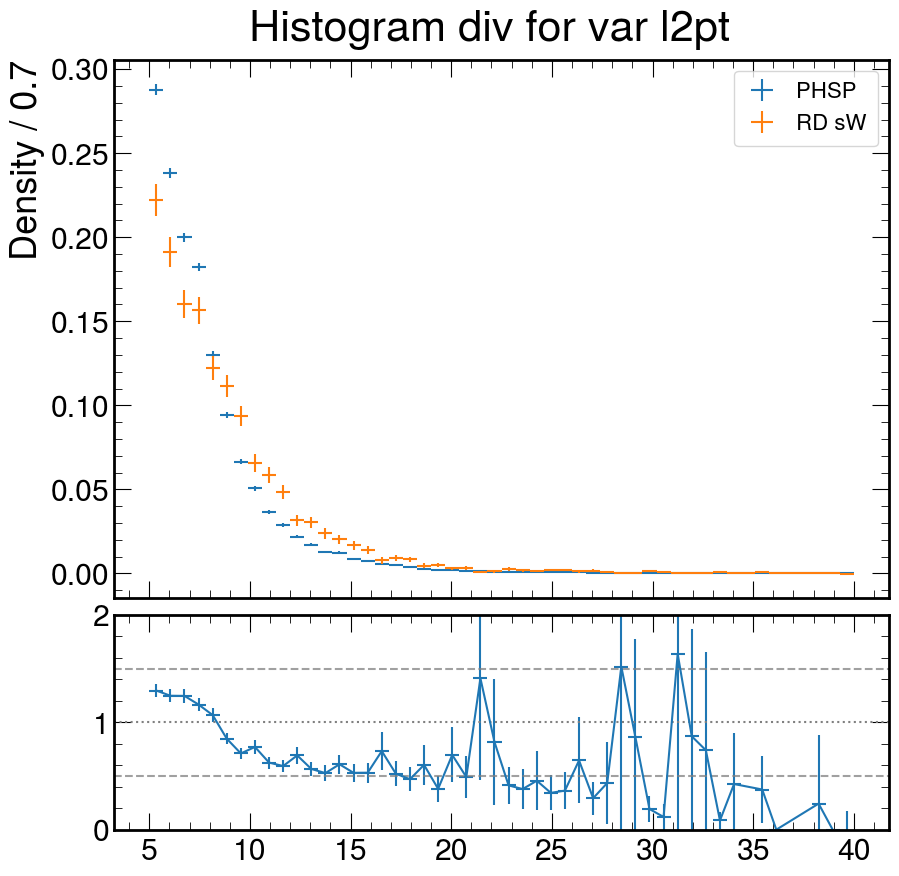

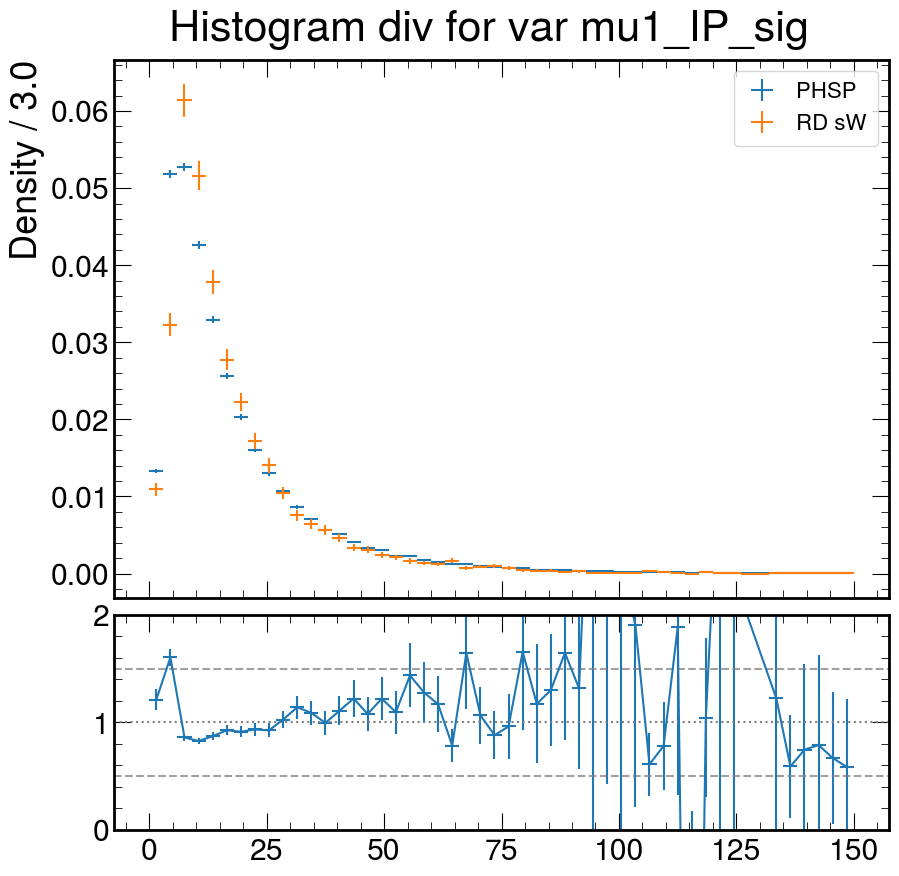

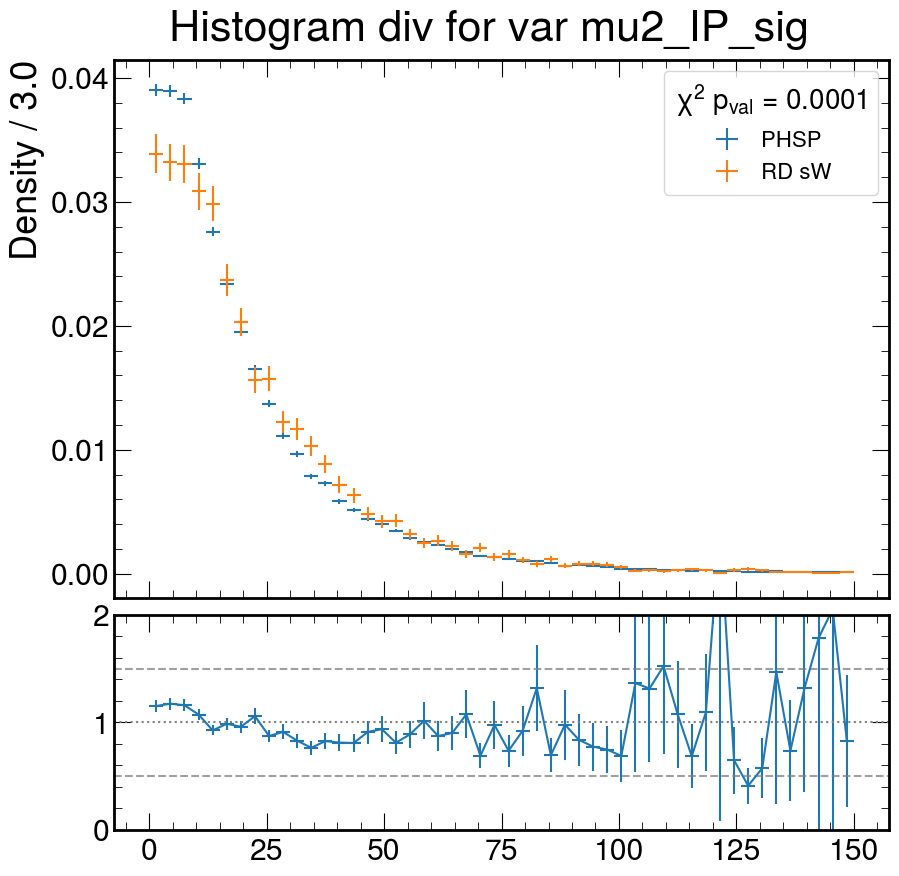

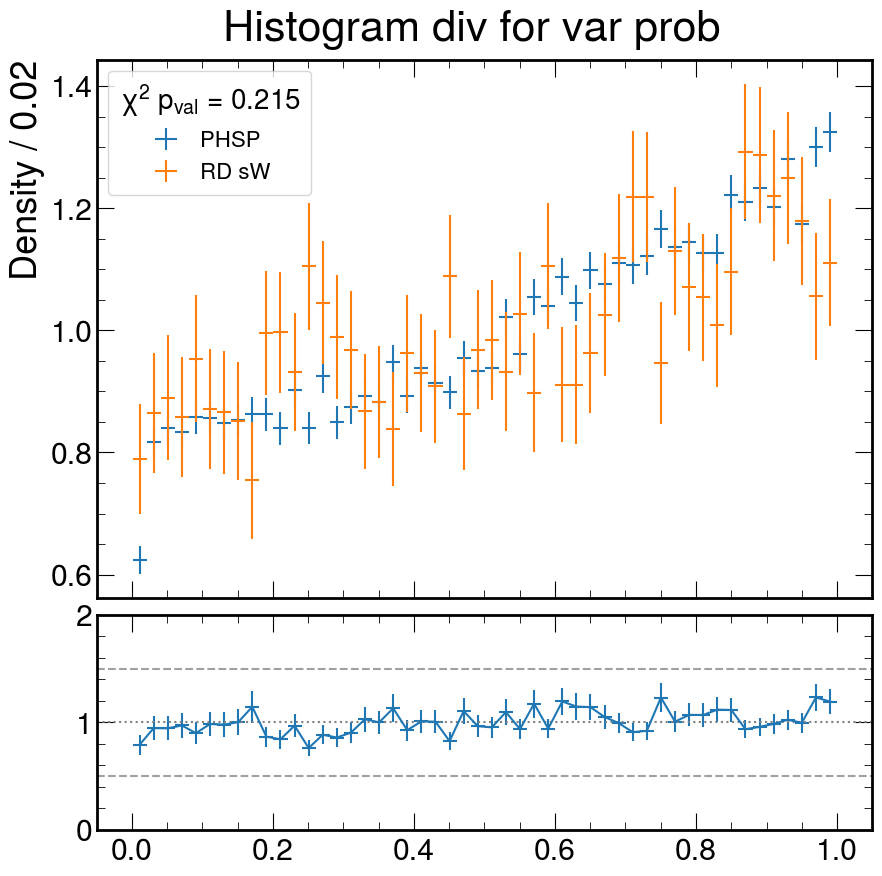

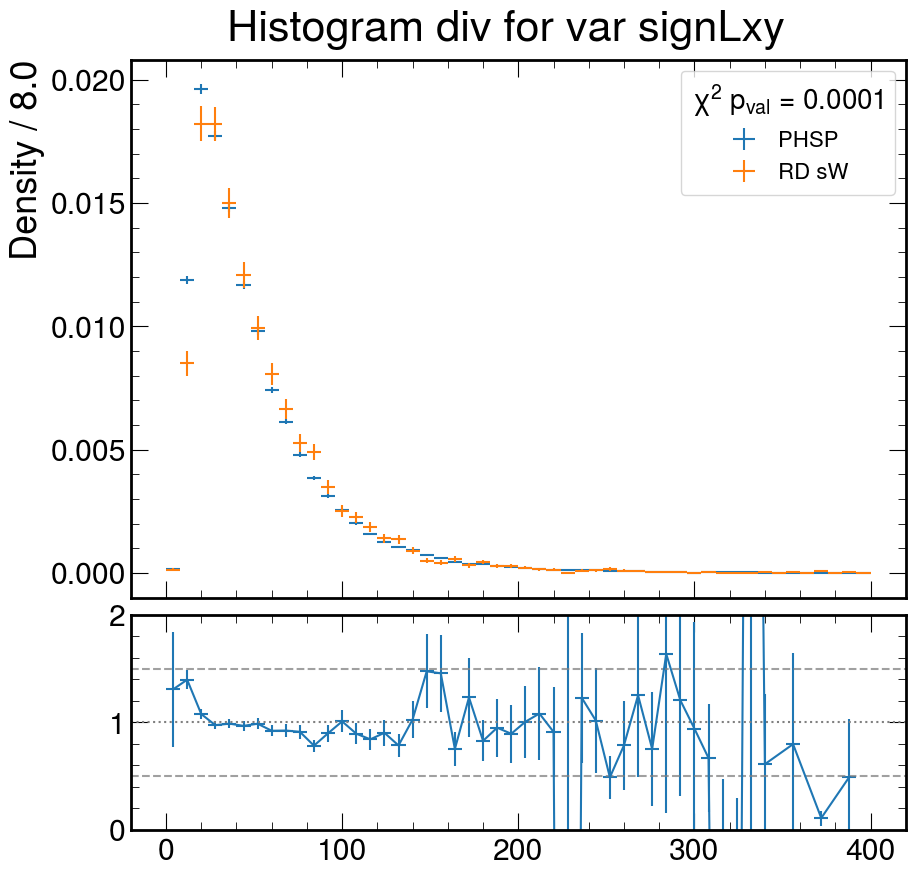

In [81]:
for col in cols:
    plot_tools.compare_plot(PHSP[col], 
                        RD[col], 
                        weights_Den=RD.sW,
                        label_Den='RD sW', 
                        label_Num='PHSP', 
                        title="Histogram div for var " + col,
                        hist_opts = dict(bins=bins, range=ranges[col]),)

Overflow  (>=150.0)
	 1.84 +- 0.56
	Unweighted  13 

Overflow  (>=150.0)
	 8.56 +- 3.07
	Unweighted  13 

Overflow  (>=0.5)
	 0.01 +- 0.01
	Unweighted  1 

Underflow (<0.999)
	 11.91 +- 1.0
	Unweighted  206 

Overflow  (>=1.0)
	 27.39 +- 2.0
	Unweighted  234 

Underflow (<0.999)
	 15.8 +- 5.32
	Unweighted  60 

Overflow  (>=1.0)
	 18.29 +- 5.07
	Unweighted  36 

Overflow  (>=2.429)
	 0.02 +- 0.02
	Unweighted  1 

Overflow  (>=2.429)
	 0.97 +- 1.12
	Unweighted  2 

Overflow  (>=70.0)
	 4.83 +- 0.89
	Unweighted  36 

Overflow  (>=70.0)
	 6.43 +- 3.06
	Unweighted  18 

Overflow  (>=75.0)
	 3.68 +- 0.78
	Unweighted  27 

Overflow  (>=75.0)
	 5.34 +- 3.1
	Unweighted  20 

Underflow (<5.0)
	 2176.31 +- 17.27
	Unweighted  22391 

Overflow  (>=40.0)
	 1.78 +- 0.59
	Unweighted  10 

Underflow (<5.0)
	 2276.27 +- 58.98
	Unweighted  5877 

Overflow  (>=40.0)
	 2.64 +- 1.96
	Unweighted  5 

Overflow  (>=150.0)
	 5.6 +- 0.88
	Unweighted  58 

Overflow  (>=150.0)
	 3.15 +- 2.17
	Unweighted  5 

Over

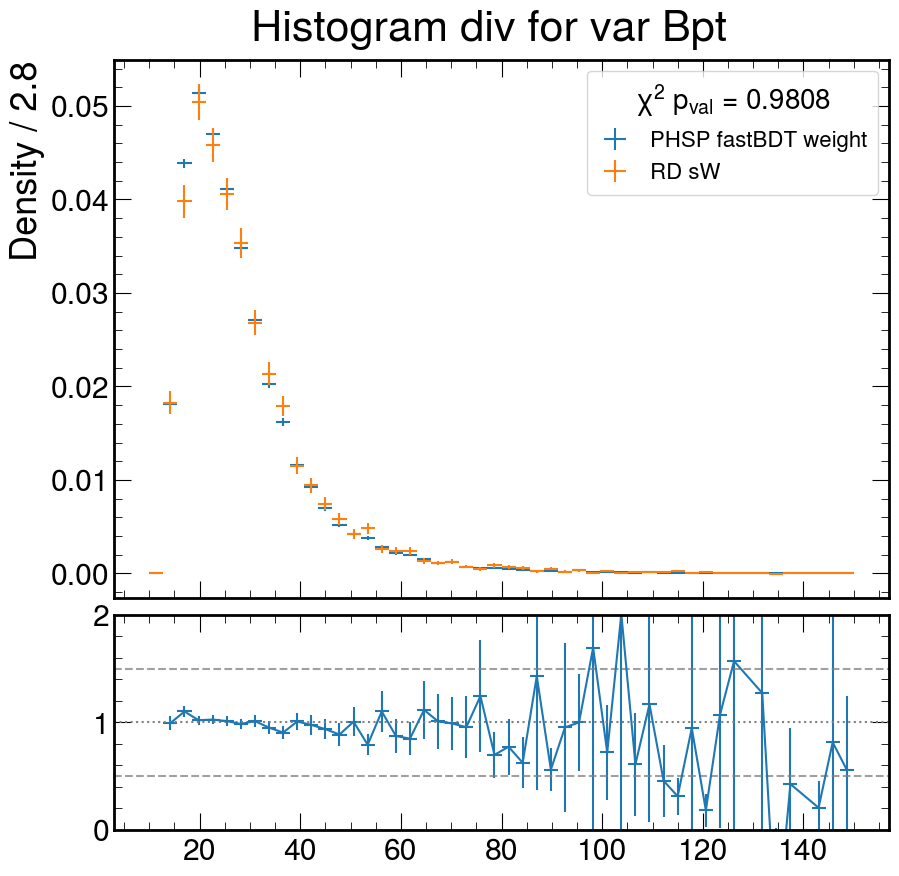

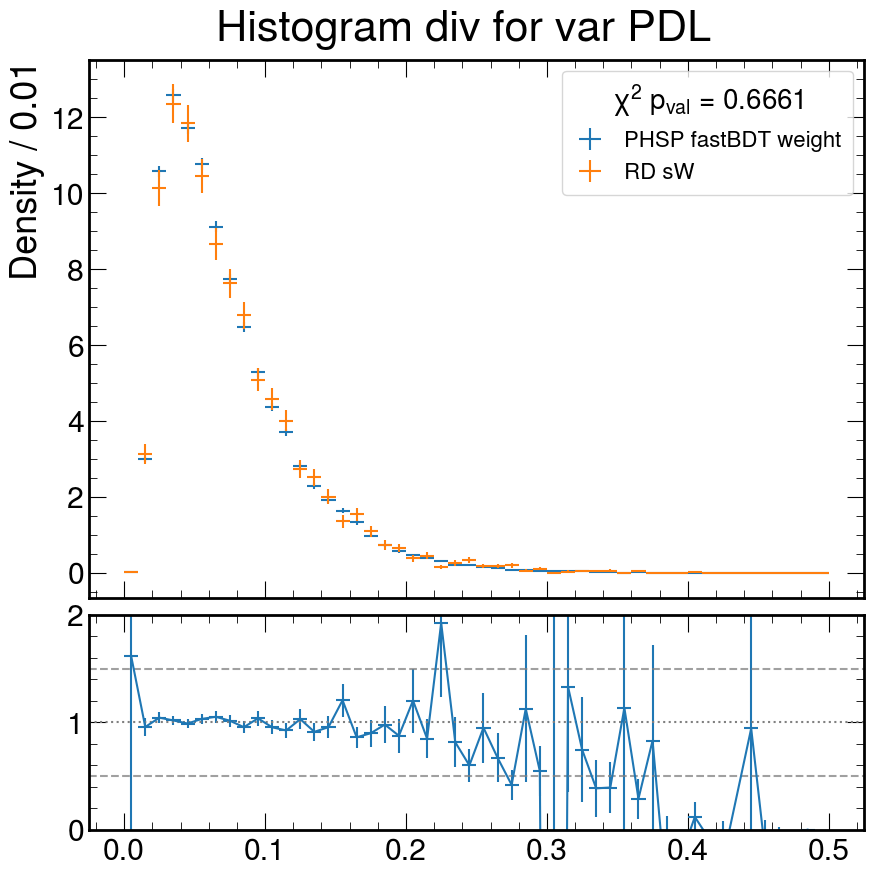

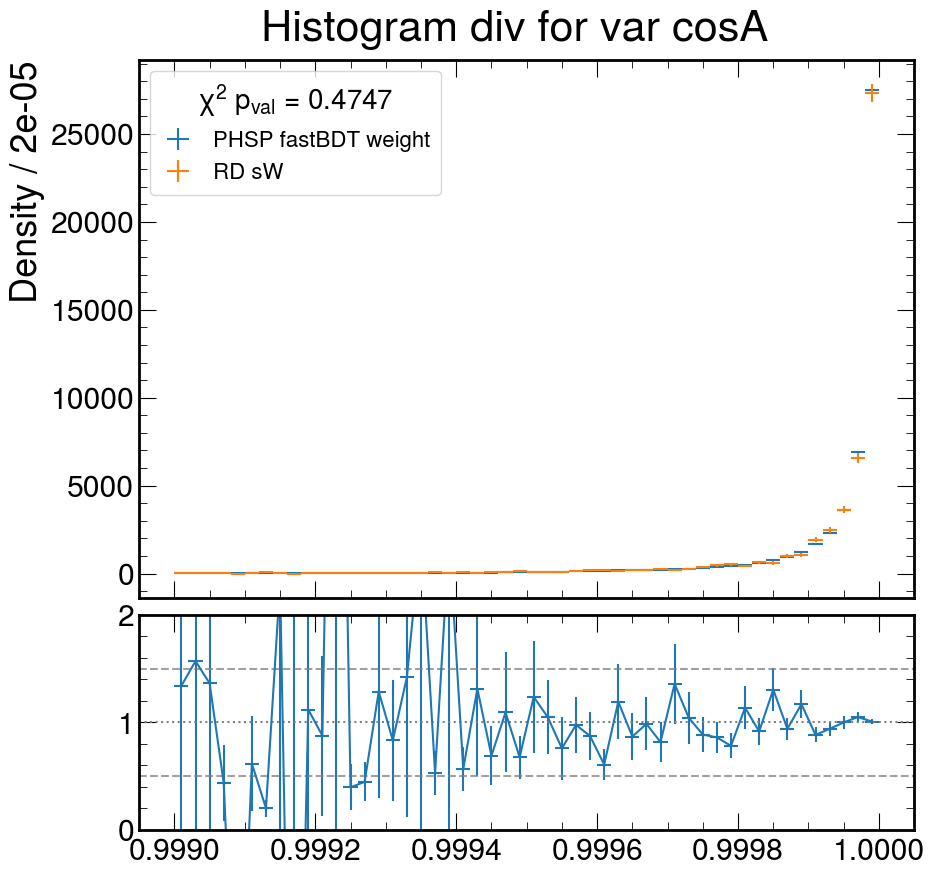

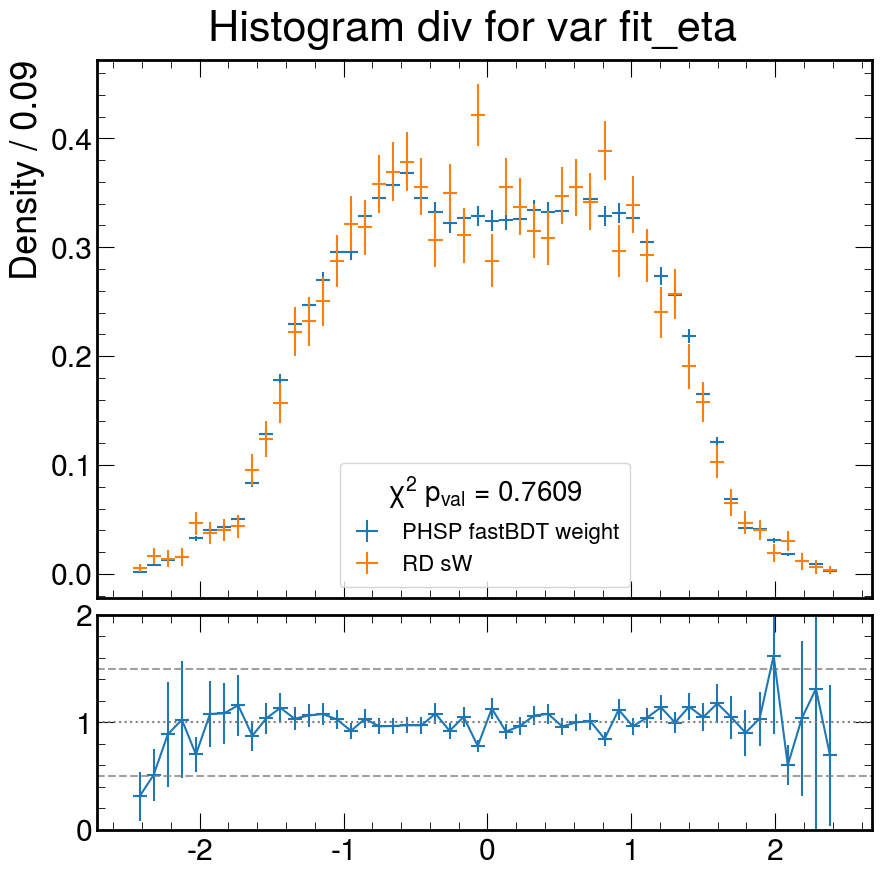

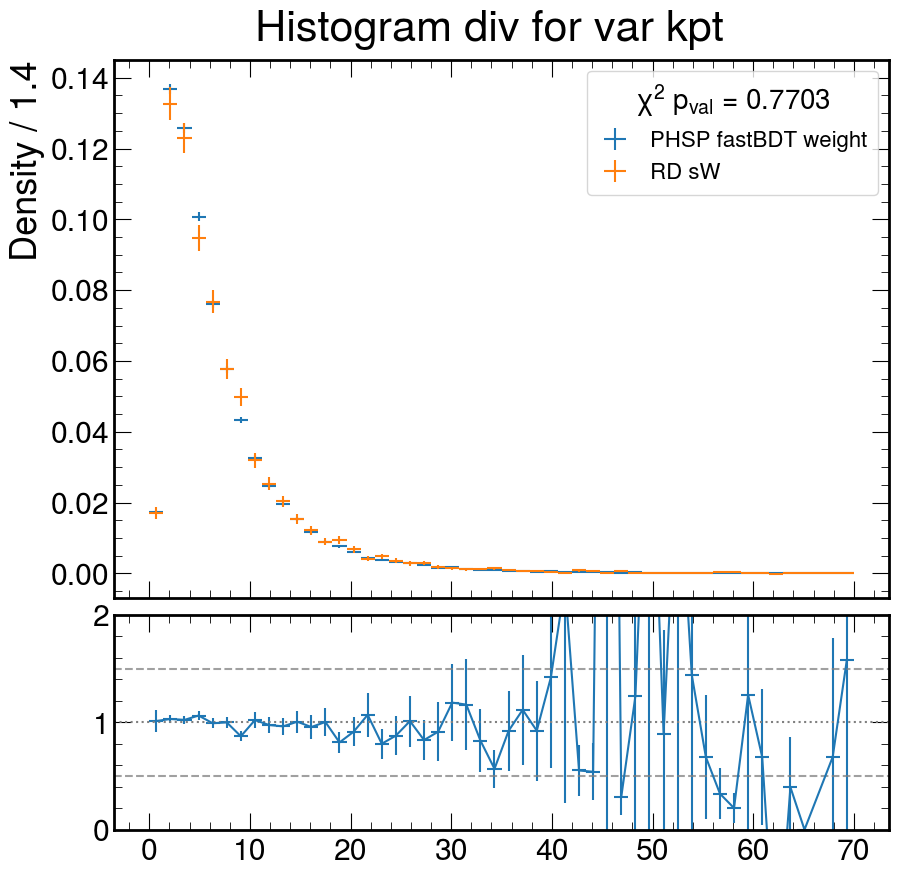

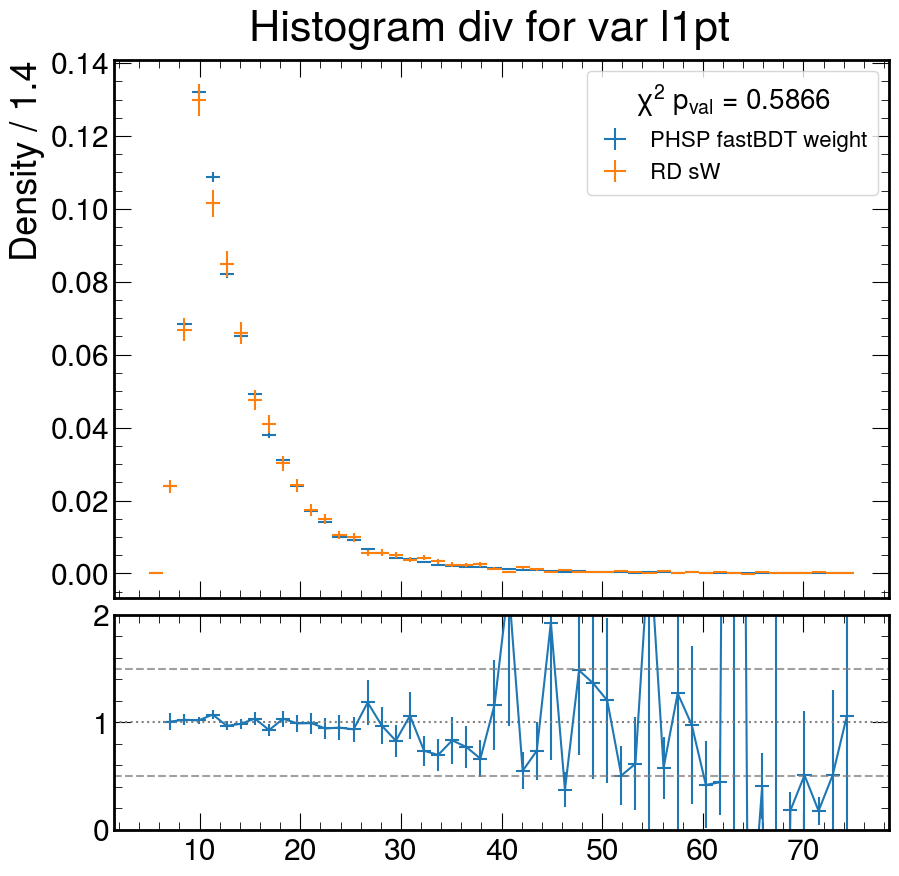

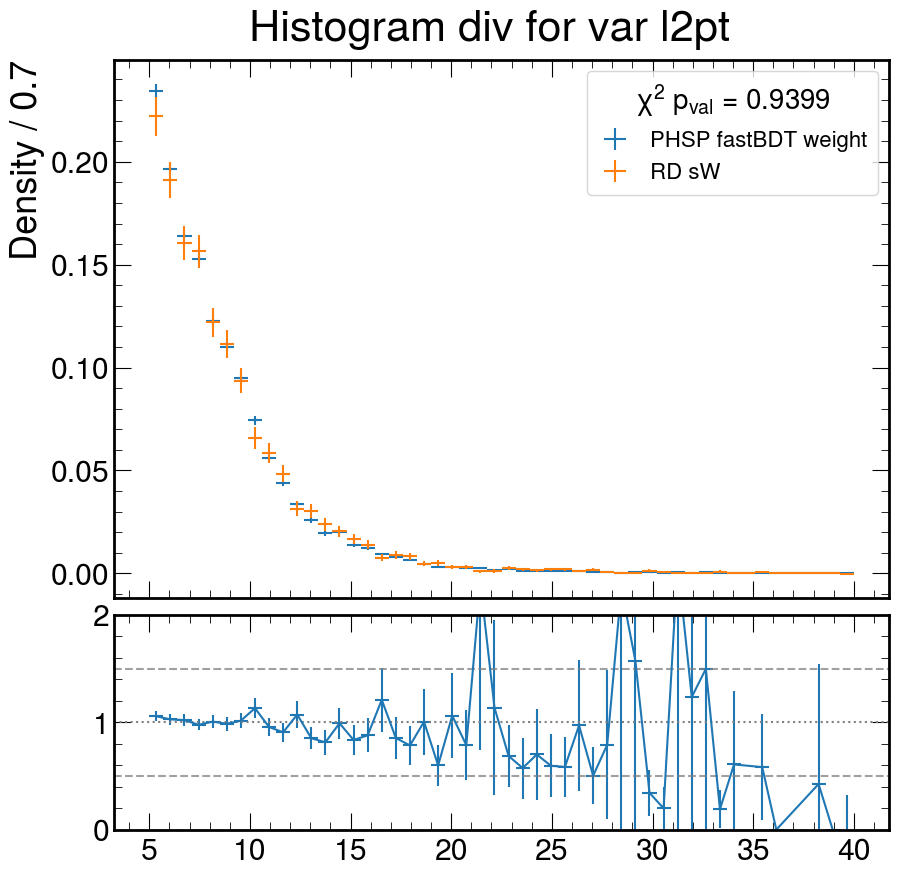

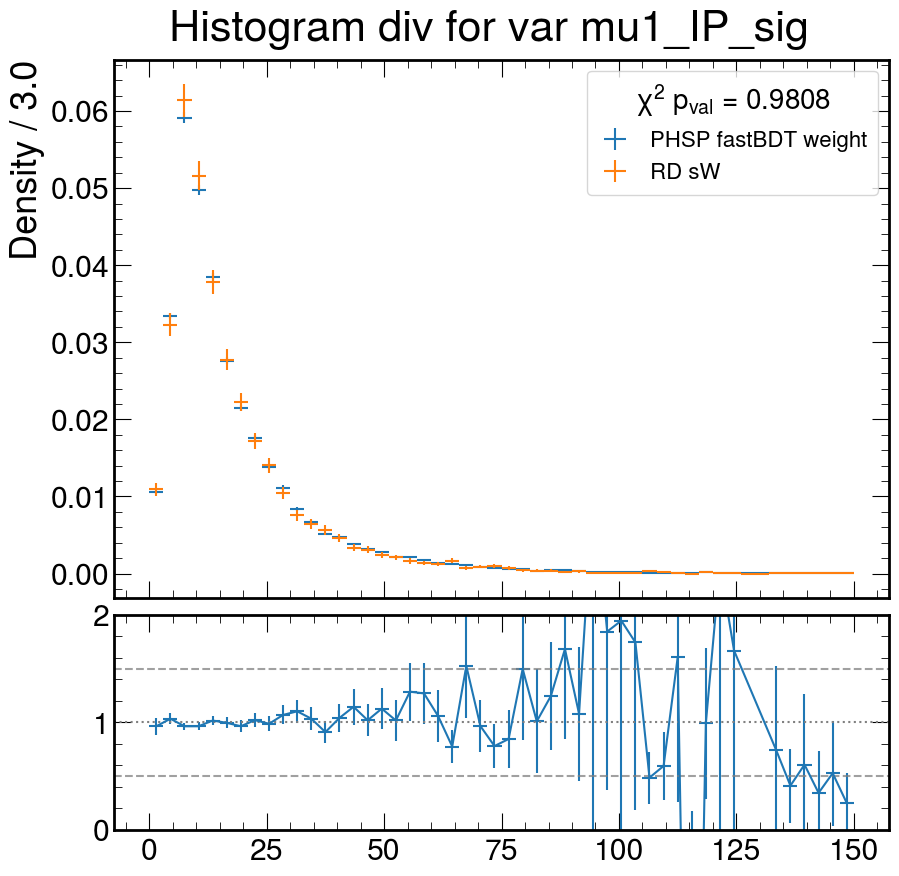

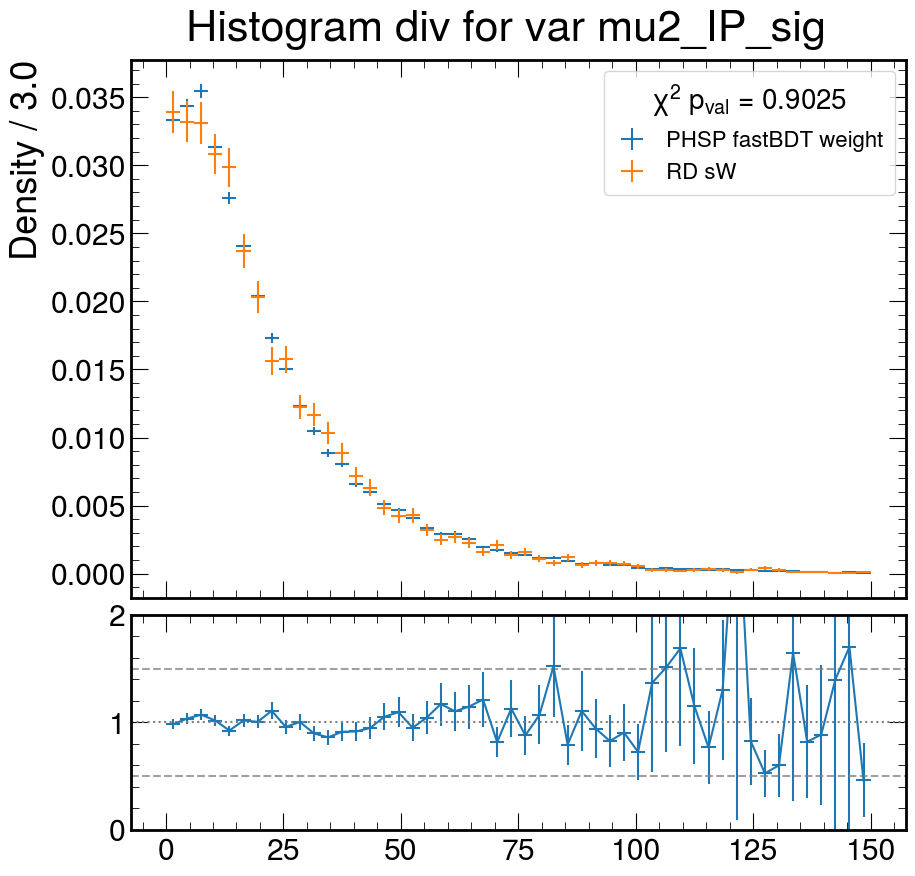

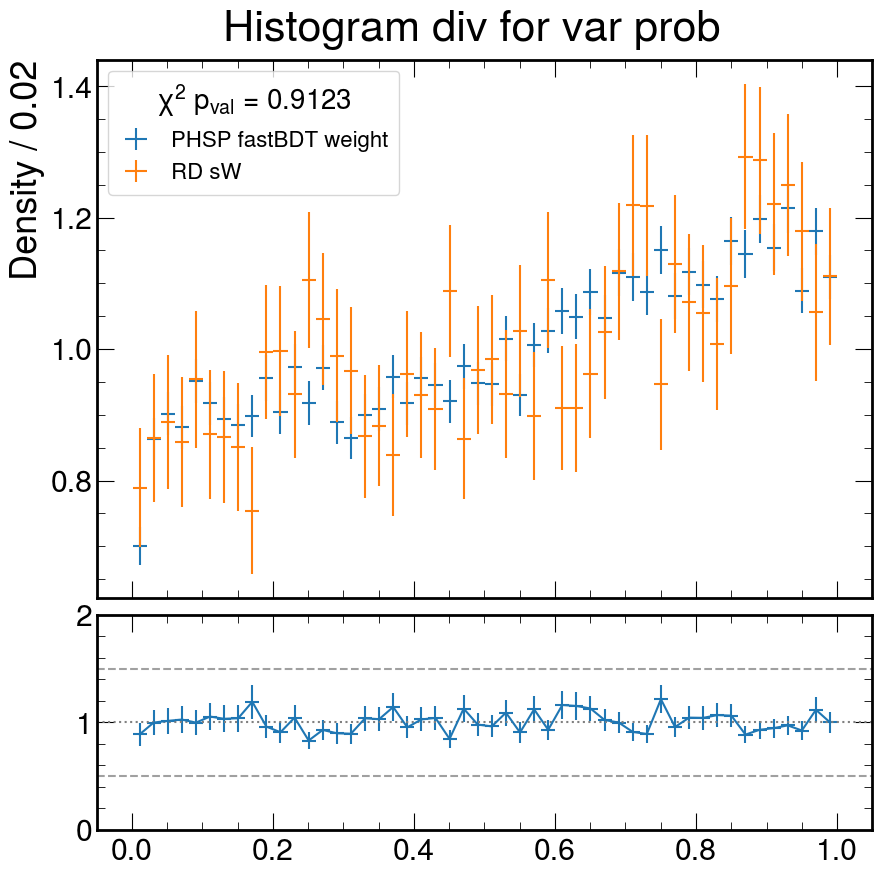

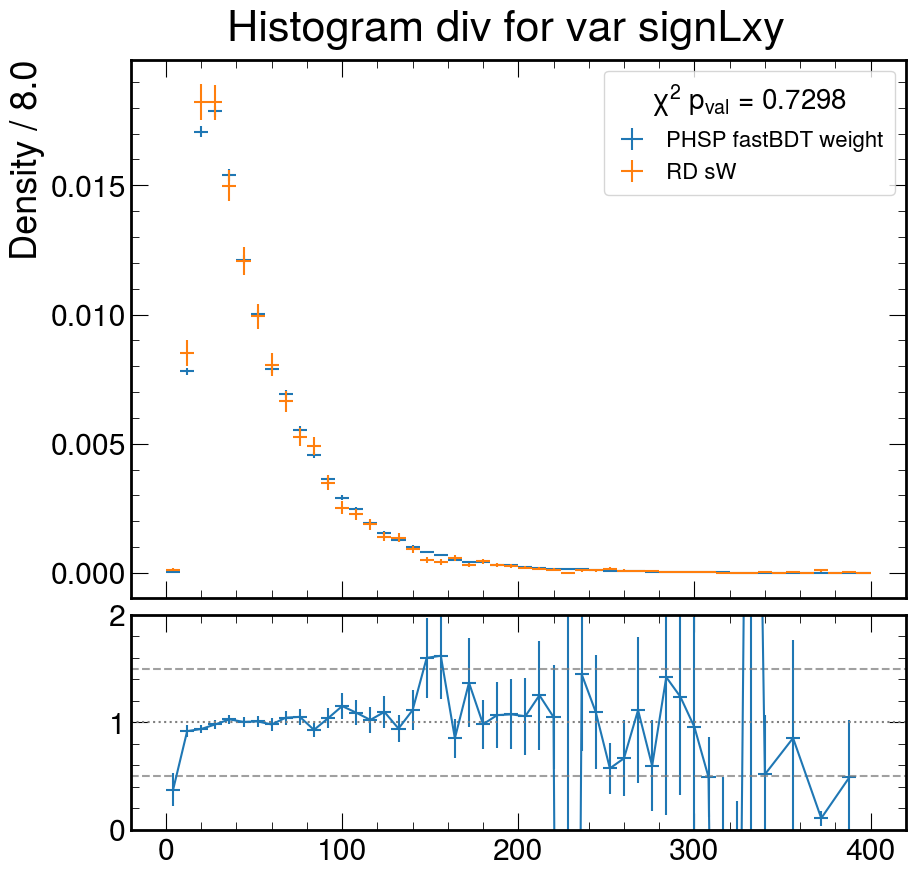

In [82]:
for col in cols:
    plot_tools.compare_plot(PHSP[col], 
                        RD[col], 
                        weights_Den=RD.sW,
                        weights_Num=new_weights,
                        label_Den='RD sW', 
                        label_Num='PHSP fastBDT weight',
                        title="Histogram div for var " + col,
                        hist_opts = dict(bins=bins, range=ranges[col]))

classifier = xgb.XGBClassifier()
classifier.fit(X=dataFrame[cols], 
               y=dataFrame.label, 
               sample_weight=dataFrame['sW'])

In [48]:
# var = cols
# for col in cols:
#     distance = ks_2samp_weighted(RD[col],
#                             PHSP[col],
#                             RD['sW'],
#                             new_weights)
#     print("col:",cols[1], ", x2=", distance[1] )

# Weight distribution comparison

In [49]:
CORR = pd.read_csv(os.path.join(data_path, f'PHSP_Complete_Corrected.csv')).query('5<=BMass<=5.7')

In [50]:
len(PHSP.columns)

118

In [51]:
len(CORR.columns)

125

In [52]:
_cols = np.setdiff1d(CORR.columns, PHSP.columns)
_cols

array(['SF_1_bm', 'SF_1var_bm', 'SF_2_bm', 'SF_2var_bm', 'SF_bm',
       'SF_var_bm', 'Slice', 'rand', 'totalW'], dtype=object)

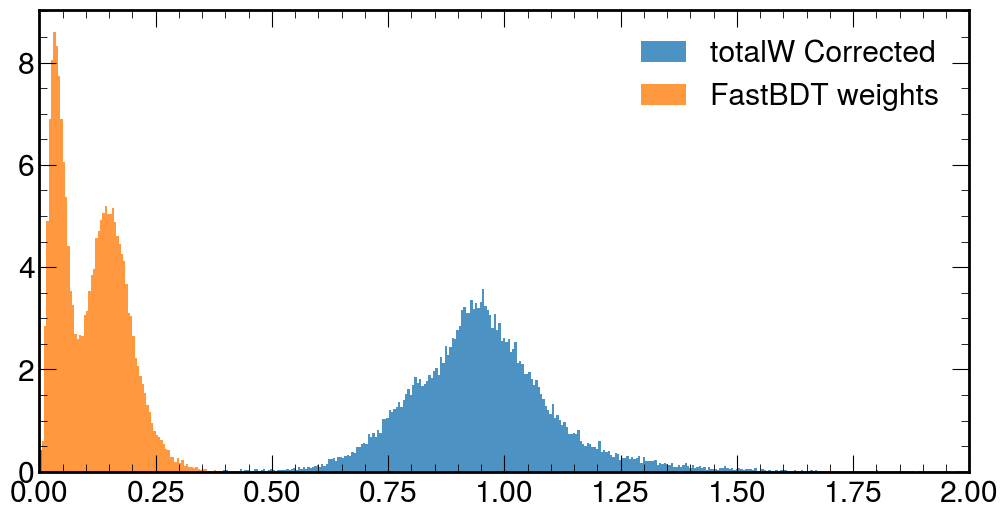

In [63]:
# The column that has the weights is totalW in CORR

#Defining the bining

fig, ax = plt.subplots(figsize=(12, 6))

bins = 1000
bins = np.histogram(np.hstack((CORR.totalW, new_weights)), bins=bins)[1]

ax.hist(CORR.totalW, bins=bins, density=True, alpha=0.8, label='totalW Corrected')
ax.hist(new_weights, bins=bins, density=True, alpha=0.8, label='FastBDT weights')


plt.legend()

plt.xlim([0, 2])

plt.show()

# Scatterplot

Text(0.5, 1.0, 'sWeights by BMass of RD')

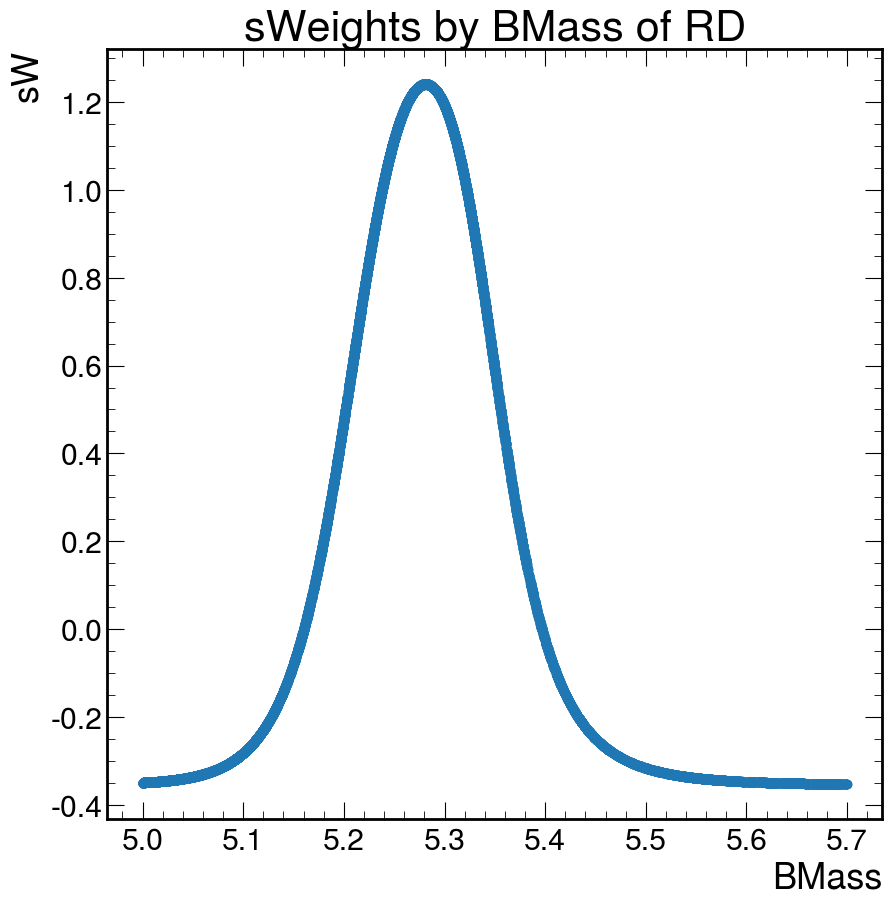

In [79]:
plt.scatter(RD['BMass'],  RD['sW'] )
plt.xlabel('BMass')
plt.ylabel('sW')
plt.title('sWeights by BMass of RD')

In [ ]:
# Hyperparameter search